Created August 17, 2023

Purpose is to update location grid search in the following ways:
1. use templates whose constituent waveforms were normalized before stacking (fixes most false features)
2. use elep to find picktimes instead of envelope cross correlation
3. improved location search - NonLinLoc
4. compare locations to ComCat potential matches from the <a href="https://assets.pnsn.org/red/">redpy website</a> when possible

last updated May 21, 2024

In [1]:
import requests
import h5py
import yaml
import csv
import math
import eqcorrscan
from eqcorrscan import Tribe
from time import time
import obspy
from obspy import UTCDateTime, Trace
import pandas as pd
from glob import glob
import numpy as np
from obspy.signal.cross_correlation import *
import matplotlib.pyplot as plt
from geopy import distance
from tqdm import trange
from scipy import signal


import torch
plt.rcParams.update({'font.size': 10})
# from utils import *


import seisbench.models as sbm
device = torch.device("cpu")

from ELEP.elep.ensemble_statistics import ensemble_statistics
from ELEP.elep.ensemble_coherence import ensemble_semblance 
from ELEP.elep.ensemble_learners import ensemble_regressor_cnn
import os
os.chdir('../../scripts') #navigate to location of mbf_elep_func.py
from mbf_elep_func import apply_mbf
from ELEP.elep import mbf, mbf_utils
from ELEP.elep import trigger_func
from ELEP.elep.trigger_func import picks_summary_simple

from ELEP.elep.mbf_utils import make_LogFq, make_LinFq, rec_filter_coeff, create_obspy_trace
from ELEP.elep.mbf import MB_filter as MBF

Matched-filter CPU is not compiled! Should be here: /home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/site-packages/fast_matched_filter/lib/matched_filter_CPU.so


In [22]:
#read config file for parameters
with open('/home/smocz/expand_redpy/scripts/config.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

smooth_length = config['smooth_length']
fs = config['fs']
tb = config['tb']
ta = config['ta']
fqmin = config['fqmin']
fqmax = config['fqmax']
chan = config['chan']
homedir = config['homedir']
readdir = config['readdir']
minsta = config['minsta']
grid_length = float(config['grid_length'])
grid_height = float(config['grid_height'])
step = config['step']
t_step = config['t_step']
vs_min = config['vs_min']
vs_max = config['vs_max']
vs_step = config['vs_step']
volc_lat_lon = config['volc_lat_lon']
volc_list_names = config['volc_list_names']
nlta = config['nlta']

# vv = config['vv']
vv=4

tape = 0.05 #percent of waveform to taper on either side

istart = int(config['nlta']*fs)
iend = int((config['nlta']+config['tb']+config['ta'])*fs)
print(istart,iend)


print(volc_list_names[vv])

volc_md = pd.read_csv(readdir+'Volcano_Metadata.csv')
#associate network and station
volc_md['netsta'] = volc_md['Network'].astype(str)+'.'+volc_md['Station'].astype(str)

400 3520
St_Helens


In [23]:
#get clusterid from template name
def getcl_id(t_name_str): #for normalized
    t_cl = int(t_name_str.split('_')[-1])
    return t_cl

In [24]:
# ML picker parameters
paras_semblance = {'dt':0.025, 'semblance_order':4, 'window_flag':True, 
                   'semblance_win':0.5, 'weight_flag':'max'}
p_thrd, s_thrd = 0.01, 0.05

# download models
pretrain_list = ["pnw","ethz","instance","scedc","stead","geofon","neic"]
pn_pnw_model = sbm.EQTransformer.from_pretrained('pnw')
pn_ethz_model = sbm.EQTransformer.from_pretrained("ethz")
pn_instance_model = sbm.EQTransformer.from_pretrained("instance")
pn_scedc_model = sbm.EQTransformer.from_pretrained("scedc")
pn_stead_model = sbm.EQTransformer.from_pretrained("stead")
pn_geofon_model = sbm.EQTransformer.from_pretrained("geofon")
pn_neic_model = sbm.EQTransformer.from_pretrained("neic")

#list of models to run through
list_models = [pn_pnw_model,pn_ethz_model,pn_scedc_model,pn_neic_model,pn_geofon_model,pn_stead_model,pn_instance_model]

pn_pnw_model.to(device); #imodel 0
pn_ethz_model.to(device); #imodel 1
pn_scedc_model.to(device); #imodel 2
pn_neic_model.to(device); #imodel 3
pn_geofon_model.to(device); #imodel 4
pn_stead_model.to(device); #imodel 5
pn_instance_model.to(device); #imodel 6

In [25]:
#pull in templates for volcano

all_temps = []
all_waves = []

for filepath in glob(f'/home/smocz/expand_redpy_new_files/h5/normalized_{volc_list_names[vv].lower()}_templates_*.h5'):
    net = filepath.split('_')[-2]
    with h5py.File(filepath, "r") as f: #pull in fingerprints
        template_name = f["template_name"][()]
        waveforms = f["waveforms"][()]
#         print(f.keys()) #print what data is in this file
    [all_temps.append(i) for i in template_name]
    [all_waves.append(i) for i in waveforms]
    
all_waves = np.array(all_waves)
all_temps = [str(i)[2:-1] for i in all_temps]

In [26]:
#get some info
v = volc_md[volc_md['Volcano_Name'] == volc_list_names[vv]]['netsta'].values.tolist() #list of network and station per volc
clid = np.unique([getcl_id(i) for i in all_temps]) #list of cluster ids
cllen = len(str(max(clid))) #length of the largest cluster ID, used for zfill
zz = chan[-2:].lower() #the last two letters of channel names (essentially the letters in chan)
csv_name = f'{homedir}locations/{volc_list_names[vv]}_ELEP_normalized_picktimes.csv' #name of the csv for picktimes at this volcano
h5_name = f'{homedir}h5/{volc_list_names[vv]}_ELEP_smb_pred.h5' #name of h5 file for smb_pred


Find picktimes

In [ ]:
# create csv for volcano
# with open(csv_name, 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(['Network','Station','Cluster_ID','Template_Name','SMB_peak']) #,'SMB_peak_MBF'
#     file.close()

In [12]:
### PULL IN TEMPLATES ###
# cl_trange = trange(max(clid), desc="Finding picktimes for each cluster", leave=True)
cl_trange=range(169,max(clid)+1) #range needs the +1
for cl in cl_trange:
#     print('------') #print a divider
#     print("cluster:",str(cl).zfill(cllen)) #print the cluster ID
    
    temps_w = [] #list of templates waveforms for this cluster
    temps_n = [] #list of template names
    temps_p = [] #list of template picks (list of arrays)
    preds = [] #pred data for looking
    
    stopwatch0=time() #note the time
    
    s_trange = trange(len(v), desc=f"Finding picktimes for each station at cluster {cl}", leave=True) #has a progress bar
#     s_trange = range(0,len(v)) #no progress bar

    rows = [] #list of rows to append to csv
    for s in s_trange: #loop through stations that have a template for this cluster
        net, sta =  v[s].split('.') #add specific network per station
        
        for tt,t in enumerate(all_temps): #go through each template
            if t.split('_')[0]==net and t.split('_')[1]==sta and t.split('_')[-1]==str(cl): #if the template is for this station and cluster
                
                ### PREPARE DATA ###
#                 Trace(all_waves[tt]).plot(); #show before preparation
                wave = all_waves[tt].copy() #create copy
                
                t_tapered = Trace(wave).taper(tape) #make waveform a trace to taper it
                padded_wave = np.hstack((t_tapered.data[:],np.zeros(2480))) #take data from tapered trace and pad end 
                #with zeros so that len(t_trace)=6000 and will fit in the nueral network
                t_trace = Trace(padded_wave,{'sampling_rate':fs}) #make back into a Trace, and set sampling rate
#                 print(len(t_trace))
                
                temps_w.append(t_trace) #append trace
                temps_n.append(t) #append name
                
#                 t_trace.plot(); #plot trace after preparation

    
                ### FIND PICKS! ###

                #picking params
                evt_data = Stream(traces=[t_trace])
                sta_available = [sta]
                list_models = list_models
                twin = len(t_trace)-1


                dt = 1/fs; fs = fs
                nfqs = 5
                nt = 6000; nc = 3
                iend = len(wave)-1 #end of possible pick times
                istart = math.ceil(tape*(len(wave)-1)) #beginning of possible pick times (currently excluding taper)
                
                fq_list = make_LogFq(fqmin, fqmax, dt, nfqs)
                coeff_HP, coeff_LP = rec_filter_coeff(fq_list, dt)
                MBF_paras = {'f_min':fqmin, 'f_max':fqmax, 'nfqs':nfqs, 'frequencies':fq_list, 'CN_HP':coeff_HP, 'CN_LP':coeff_LP,                     'dt':dt, 'fs':fs, 'nt':nt, 'nc':nc, 'npoles': 2}

                paras_semblance = {'dt':dt, 'semblance_order':2, 'window_flag':True, 
                                   'semblance_win':0.5, 'weight_flag':'max'}
                
                #find picktimes!
                peaks,smb_pred = apply_mbf(evt_data, sta_available,                 list_models, MBF_paras, paras_semblance, istart, iend) #smb_peak,smb_peak_mbf,
                
                
                print(peaks[0]) # THESE PICKS ARE OFFSET BY ISTART
                
                picks = [i+istart for i in peaks[0]] # ADDED ISTART
                temps_p.append(picks)
                csv_picks=' '.join([str(i/fs)for i in picks]) #formatted for saving in csv
                
                preds.append([smb_pred])
        
                #append picks to csv
                row = [net, sta, cl, t, csv_picks] ### APPEND PICKS NOT PEAKS
                rows.append(row)
                
    if len(temps_n)==0:
        print(f'no templates for cluster {cl}')
        continue

    ### FILTERING PEAKS ###

    one_peak = [] #list of n and y if the template only has one peak/picktime
    for p in temps_p: #for saved picks
        if len(p)==1:
            one_peak.append('y')
        else:
            one_peak.append('n')
            
            
    if one_peak.count('y')/len(one_peak) ==1: #if there is only one peak per template
        #write info to csv as is
        for row in rows:
            with open(csv_name, 'a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(row)
                file.close()

    if one_peak.count('y')/len(one_peak) >=0.5 and one_peak.count('y')/len(one_peak) <1: #if 75% of templates have one peak

        one_p_value = [] #list of peak values when there is only one
        for peaks in temps_p:
            if len(peaks)==1:
                one_p_value.append(peaks[0])
            else:
                continue

        for en,peaks in enumerate(temps_p):
            if len(peaks)>1:
                sums = []#list of sum of differences between possible peaks and the "confirmed" peaks
                for peak in peaks:
                    sums.append(sum([abs(peak-v) for v in one_p_value]))
                closest_peak = peaks[sums.index(min(sums))] #find which peak has the smallest summed distance

            else:
                continue

            rows[en][-1] = str(closest_peak/fs) #update the corresponding row's pick for csv

        #write updated info to csv
        for row in rows:
            with open(csv_name, 'a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(row)
                file.close()


    if one_peak.count('y')/len(one_peak) <0.5:

        for en,peaks in enumerate(temps_p):
            if len(peaks)>1:
                rows[en][-1] = 'UNCERTAIN'

        #write updated info to csv
        for row in rows:
            with open(csv_name, 'a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(row)
                file.close()


    #save smb_pred to h5
    try:
        open(h5_name)
        with h5py.File(h5_name, "a") as f: #append info
            f.create_dataset(f"smb_pred_cl_{cl}", data=np.array(preds))
            f.create_dataset(f"template_names_cl_{cl}", data=temps_n)
    except:
        with h5py.File(h5_name, "w") as f: #create file
            f.create_dataset(f"smb_pred_cl_{cl}", data=np.array(preds))
            f.create_dataset(f"template_names_cl_{cl}", data=temps_n)

    for row in rows: #print info for testing
        print(row)
                    
    ### PLOT ###
    height = len(temps_w)
    fig, ax0 = plt.subplots(figsize=(6,height))

    yscale = 2 #how far to space waveforms from eachother
    wavecolor = 'black'
    for ww, wave in enumerate(temps_w):
        ax0.plot(wave.data[:]/np.max(np.abs(wave.data))+yscale+(yscale*ww),color=wavecolor,linewidth=.5)
        for i in temps_p[ww]: 
            plt.vlines(x=i,ymin=(yscale+(yscale*ww))-(0.5*yscale),ymax=(yscale+(yscale*ww))+(0.5*yscale),color='red')
    plt.vlines(x=nlta*fs,ymin=0,ymax=(yscale+(yscale*ww))+(0.5*yscale),color='gray',linestyle='dashed')
    #RED is possible pick times
    #GRAY is the 10 second mark/end noise window for SNR

    ax0.tick_params(axis='y', which='both',left=False,labelleft=False)


    fig.suptitle(f'Cluster {cl} on {volc_list_names[vv]}')
    fig.set_tight_layout(True)
    plt.show()
    plt.close()

  
    break

Finding picktimes for each station at cluster 37:   6%|▋         | 1/16 [01:06<16:33, 66.26s/it]


KeyboardInterrupt: 

### Visually Confirming UNCERTAIN peaks

In [ ]:
#read h5 file and show smb_pred (probability of pick)
cl = 1

with h5py.File(h5_name, "r") as f:
#     print(f.keys())
    h5_t_names = f[f"template_names_cl_{cl}"][()]
    smb = f[f"smb_pred_cl_{cl}"][()]

print(h5_t_names)

for ss,s in enumerate(smb):
    plt.plot(s[0][0]);
    plt.title(h5_t_names[ss])
    plt.show()
    plt.close()

In [ ]:
#find peaks from h5 smb_pred
#same filters as in mbf_elep_func.py
cl_peaks = []

for ss,s in enumerate(smb):
    peaks = signal.find_peaks(s[0][0][istart:iend],distance=5*fs, height=0.03)

    if len(peaks[0]) == 0:
        peaks = signal.find_peaks(s[0][0][istart:iend],distance=5*fs)
        
    poss_picks = [i+istart for i in peaks[0]]
    print([p/fs for p in poss_picks], h5_t_names[ss]) #prints possible picktimes in seconds and template name
    cl_peaks.append(poss_picks)

In [ ]:
#plot from h5 data
    
    
#find template waveforms
temps_w = [] #list of templates waveforms for this cluster
s_trange = trange(len(v), desc=f"plotting for each station at cluster {cl}", leave=True) #has a progress bar

for s in s_trange: #loop through stations that have a template for this cluster
    net, sta =  v[s].split('.') #add specific network per station

    for tt,t in enumerate(all_temps): #go through each template
        if t.split('_')[0]==net and t.split('_')[1]==sta and t.split('_')[-1]==str(cl): #if the template is for this station and cluster

            ### PREPARE DATA ###
            wave = all_waves[tt].copy() #create copy

            t_tapered = Trace(wave).taper(tape) #make waveform a trace to taper it
            padded_wave = np.hstack((t_tapered.data[:],np.zeros(2480))) #take data from tapered trace and pad end 
            #with zeros so that len(t_trace)=6000 and will fit in the nueral network
            t_trace = Trace(padded_wave,{'sampling_rate':fs}) #make back into a Trace, and set sampling rate

            temps_w.append(t_trace) #append trace


#plot
height = len(temps_w)*2
fig, ax0 = plt.subplots(figsize=(6,height))

yscale = 2 #how far to space waveforms from eachother
wavecolor = 'black'
for ww, wave in enumerate(temps_w):
    ax0.plot(wave.data[:]/np.max(np.abs(wave.data))+yscale+(yscale*ww),color=wavecolor,linewidth=.5)
    for i in cl_peaks[ww]: 
        plt.vlines(x=i,ymin=(yscale+(yscale*ww))-(0.5*yscale),ymax=(yscale+(yscale*ww))+(0.5*yscale),color='red')
        
for line, name in zip(ax0.lines, h5_t_names): #label each waveform with the cluster id
    y = line.get_ydata()[-1] #find the y value where the line ends
    ax0.annotate(str(name).split('_')[1], xy=(1,y), xytext=(6,0), color='red', 
                xycoords = ax0.get_yaxis_transform(), textcoords="offset points",
                size=10, va="center")
        
        
plt.vlines(x=nlta*fs,ymin=0,ymax=(yscale+(yscale*ww))+(0.5*yscale),color='gray',linestyle='dashed')
#RED is possible pick times
#GRAY is the 10 second mark/end noise window for SNR

ax0.tick_params(axis='y', which='both',left=False,labelleft=False)


fig.suptitle(f'Cluster {cl} on {volc_list_names[vv]}')
fig.set_tight_layout(True)
plt.show()
plt.close()

### CSV to NLLoc

In [1]:
#Read the csv and make .nlloc_obs files from them, so that we can get locations in NonLinLoc

In [27]:
print(csv_name)

/home/smocz/expand_redpy_new_files/locations/St_Helens_ELEP_normalized_picktimes.csv


In [ ]:
import os
nloc_path = f'{homedir}locations/{volc_list_names[vv]}_nnl'
if not os.path.exists(nloc_path): #if the directory doesn't already exist
    os.makedirs(nloc_path) #make the directory
    
pick_df = pd.read_csv(csv_name)

for cl in np.unique(pick_df["Cluster_ID"].values.tolist()):
    
    print('-----')
    print('Cluster',cl)
    
    nets = pick_df[pick_df["Cluster_ID"]==cl]["Network"].values.tolist()
    stas = pick_df[pick_df["Cluster_ID"]==cl]["Station"].values.tolist()
    picks = pick_df[pick_df["Cluster_ID"]==cl]["SMB_peak"].values.tolist()
        

    rows = []
    for nn, n in enumerate(nets):
        
        if picks[nn]!='UNCERTAIN': #if the pick is a number

            if nn==len(nets)-1: #if this is the last line, no new line ('\n') at the end
                row = f'{n}_{stas[nn]} ?    Z    e P      ? 20231116 0000  {"{0:.4f}".format(float(picks[nn]))} GAU  6.00e-02 -1.00e+00 -1.00e+00 -1.00e+00  1.00e+00'
    #             print('last')
            else:
                row = f'{n}_{stas[nn]} ?    Z    e P      ? 20231116 0000  {"{0:.4f}".format(float(picks[nn]))} GAU  6.00e-02 -1.00e+00 -1.00e+00 -1.00e+00  1.00e+00\n'
    #             print('not last')
            rows.append(row)
        
        else: #if the pick is 'UNCERTAIN'
            continue #skip this line
            
    [print(r) for r in rows]
    
    
    if len(rows)<3: #if there are less than 3 lines in this nlloc file, do not save it
        continue
    
    nloc_name = nloc_path+f'/{volc_list_names[vv]}_{cl}.nlloc_obs'
    
    print(f'Length of rows is {len(rows)} so we are saving...')
    
    with open(nloc_name,"w") as file:
        file.write(f'PUBLIC_ID {volc_list_names[vv]}_{cl}\n')
        file.write('QUALITY  Pmax -1 MFmin -1 MFmax -1 RMS -1 Nphs -1 Gap -1 Dist -1 Mamp -9.99 0 Mdur -9.99 0\n')
        file.write('PHASE ID Ins Cmp On Pha  FM Date     HrMn   Sec     Err  ErrMag    Coda      Amp       Per       PriorWt\n')
        file.writelines(rows)
        file.close()

#     break
    

---

Plotting

grdblend [NOTICE]: Remote data courtesy of GMT data server oceania [http://oceania.generic-mapping-tools.org]
grdblend [NOTICE]: SRTM15 Earth Relief v2.6 original at 15x15 arc seconds [Tozer et al., 2019].
grdblend [NOTICE]:   -> Download 10x10 degree grid tile (earth_relief_15s_p): N40W130


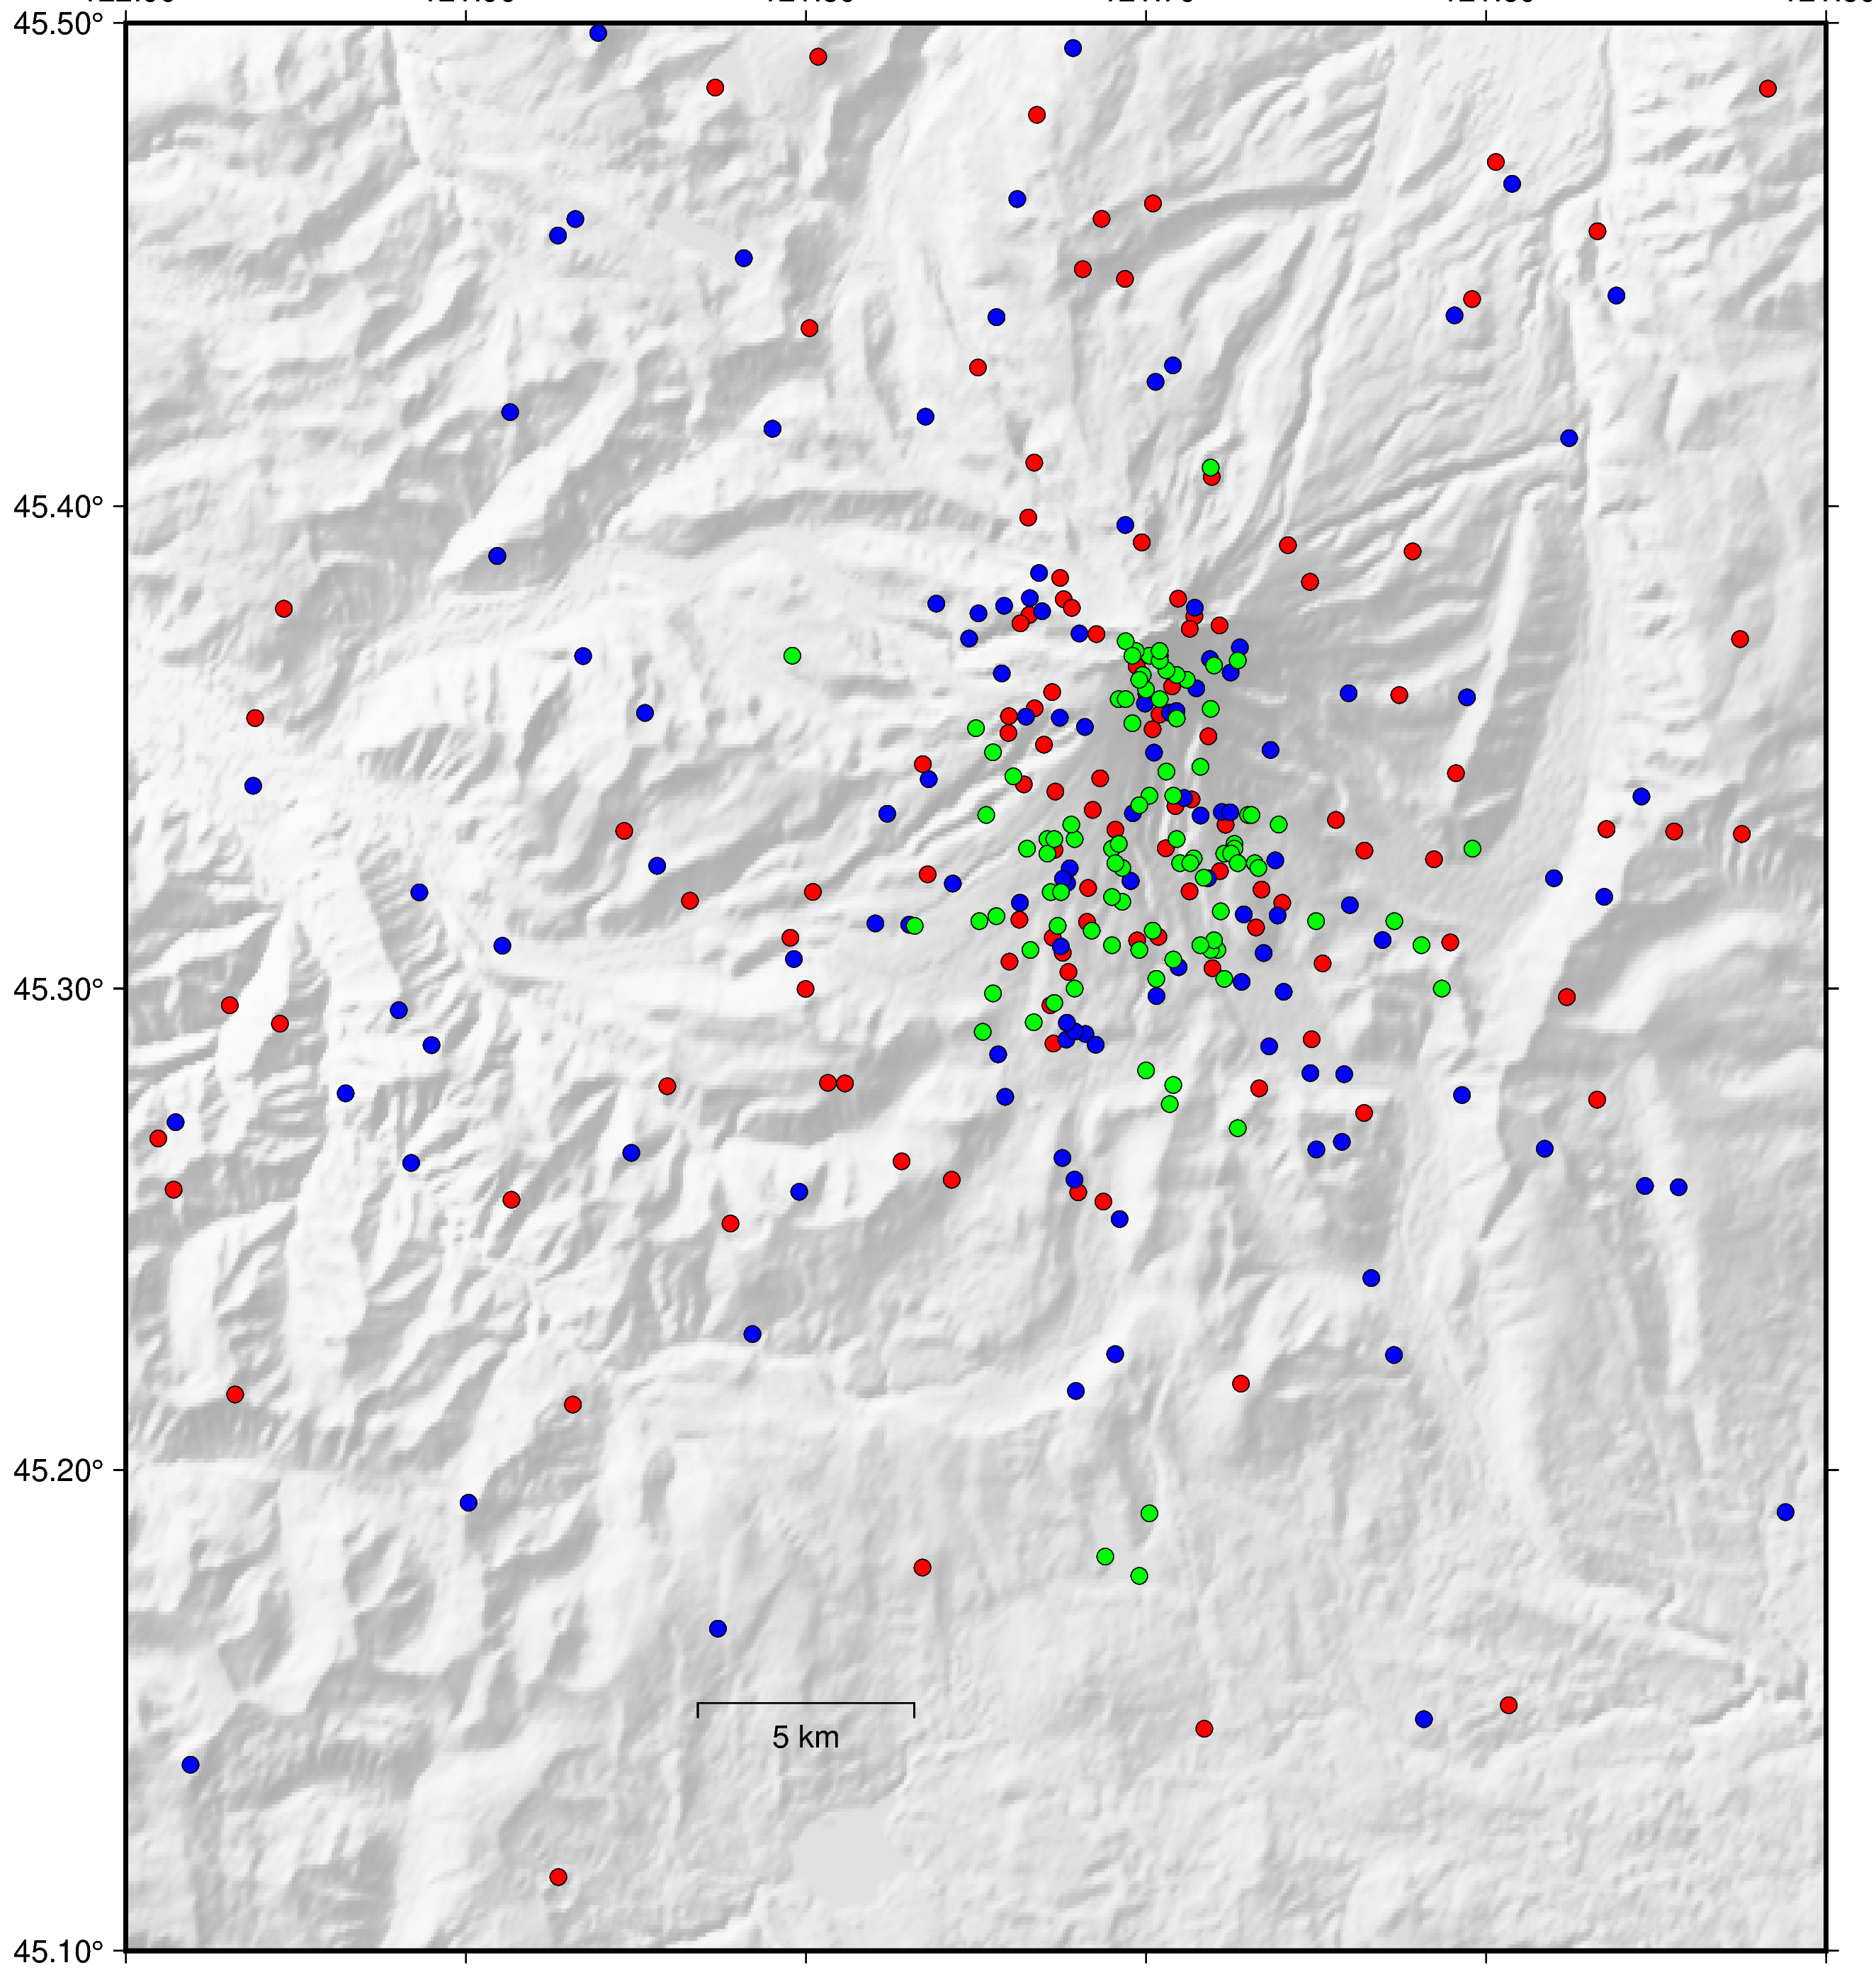

In [19]:
import pandas as pd
import pygmt

# #####if you have pygmt installed, you can run this script. # 
### Point to the files and read them in using pandas vvvvv

nsd = pd.read_csv('/home/smocz/expand_redpy_new_files/locations/nick_hood_NSD.RELOC_CLEANED') #locations that didn't use station delays. 
sd = pd.read_csv('/home/smocz/expand_redpy_new_files/locations/nick_hood_SD.RELOC_CLEANED') # locations that did use station delays. 

###  This will take care of the rest of the basic plotting. 

fig=pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE="plain")
pygmt.config(FORMAT_GEO_MAP="ddd.xx")
r=[-122,-121.5,45.1,45.5]
topo_data = '@earth_relief_03s' #30 arc second global relief (SRTM15+V2.1 @ 1.0 km)
colormap = pygmt.makecpt(
    cmap="grayC",
    series='0/5000/100',
    continuous=True)
fig.grdimage(
    grid=topo_data,
    region=r,
    projection='M8i',
    shading = True,
    cmap=colormap,
    transparency=50
)

fig.basemap(region=r,projection = 'M8i', frame=["a0.1","NWes"],map_scale="g-121.8/45.15+w5")
fig.plot(
    x=sd.mLong,
    y=sd.mLat,
    style="c0.2c",
    fill='red',
    pen='black',
#     transparency=50
)
fig.plot(
    x=nsd.mLong,
    y=nsd.mLat,
    style="c0.2c",
    fill='blue',
    pen='black',
#     transparency=50
)
fig.plot(
    x=cc_df.Longitude,
    y=cc_df.Latitude,
    style="c0.2c",
    fill='green',
    pen='black',
#     transparency=50
)
fig.show()

### Below is the the syntax to save the figure; change the location to where you want to save if you want to save. 
# fig.savefig('FIGURE_1.png',dpi=600)

cluster 0
red (station delay) Lat [45.305575] Long [-121.740132]
blue (NO station delay) Lat [45.277508] Long [-121.741417]
green (Comcat) Lat [45.291] Long [-121.748]


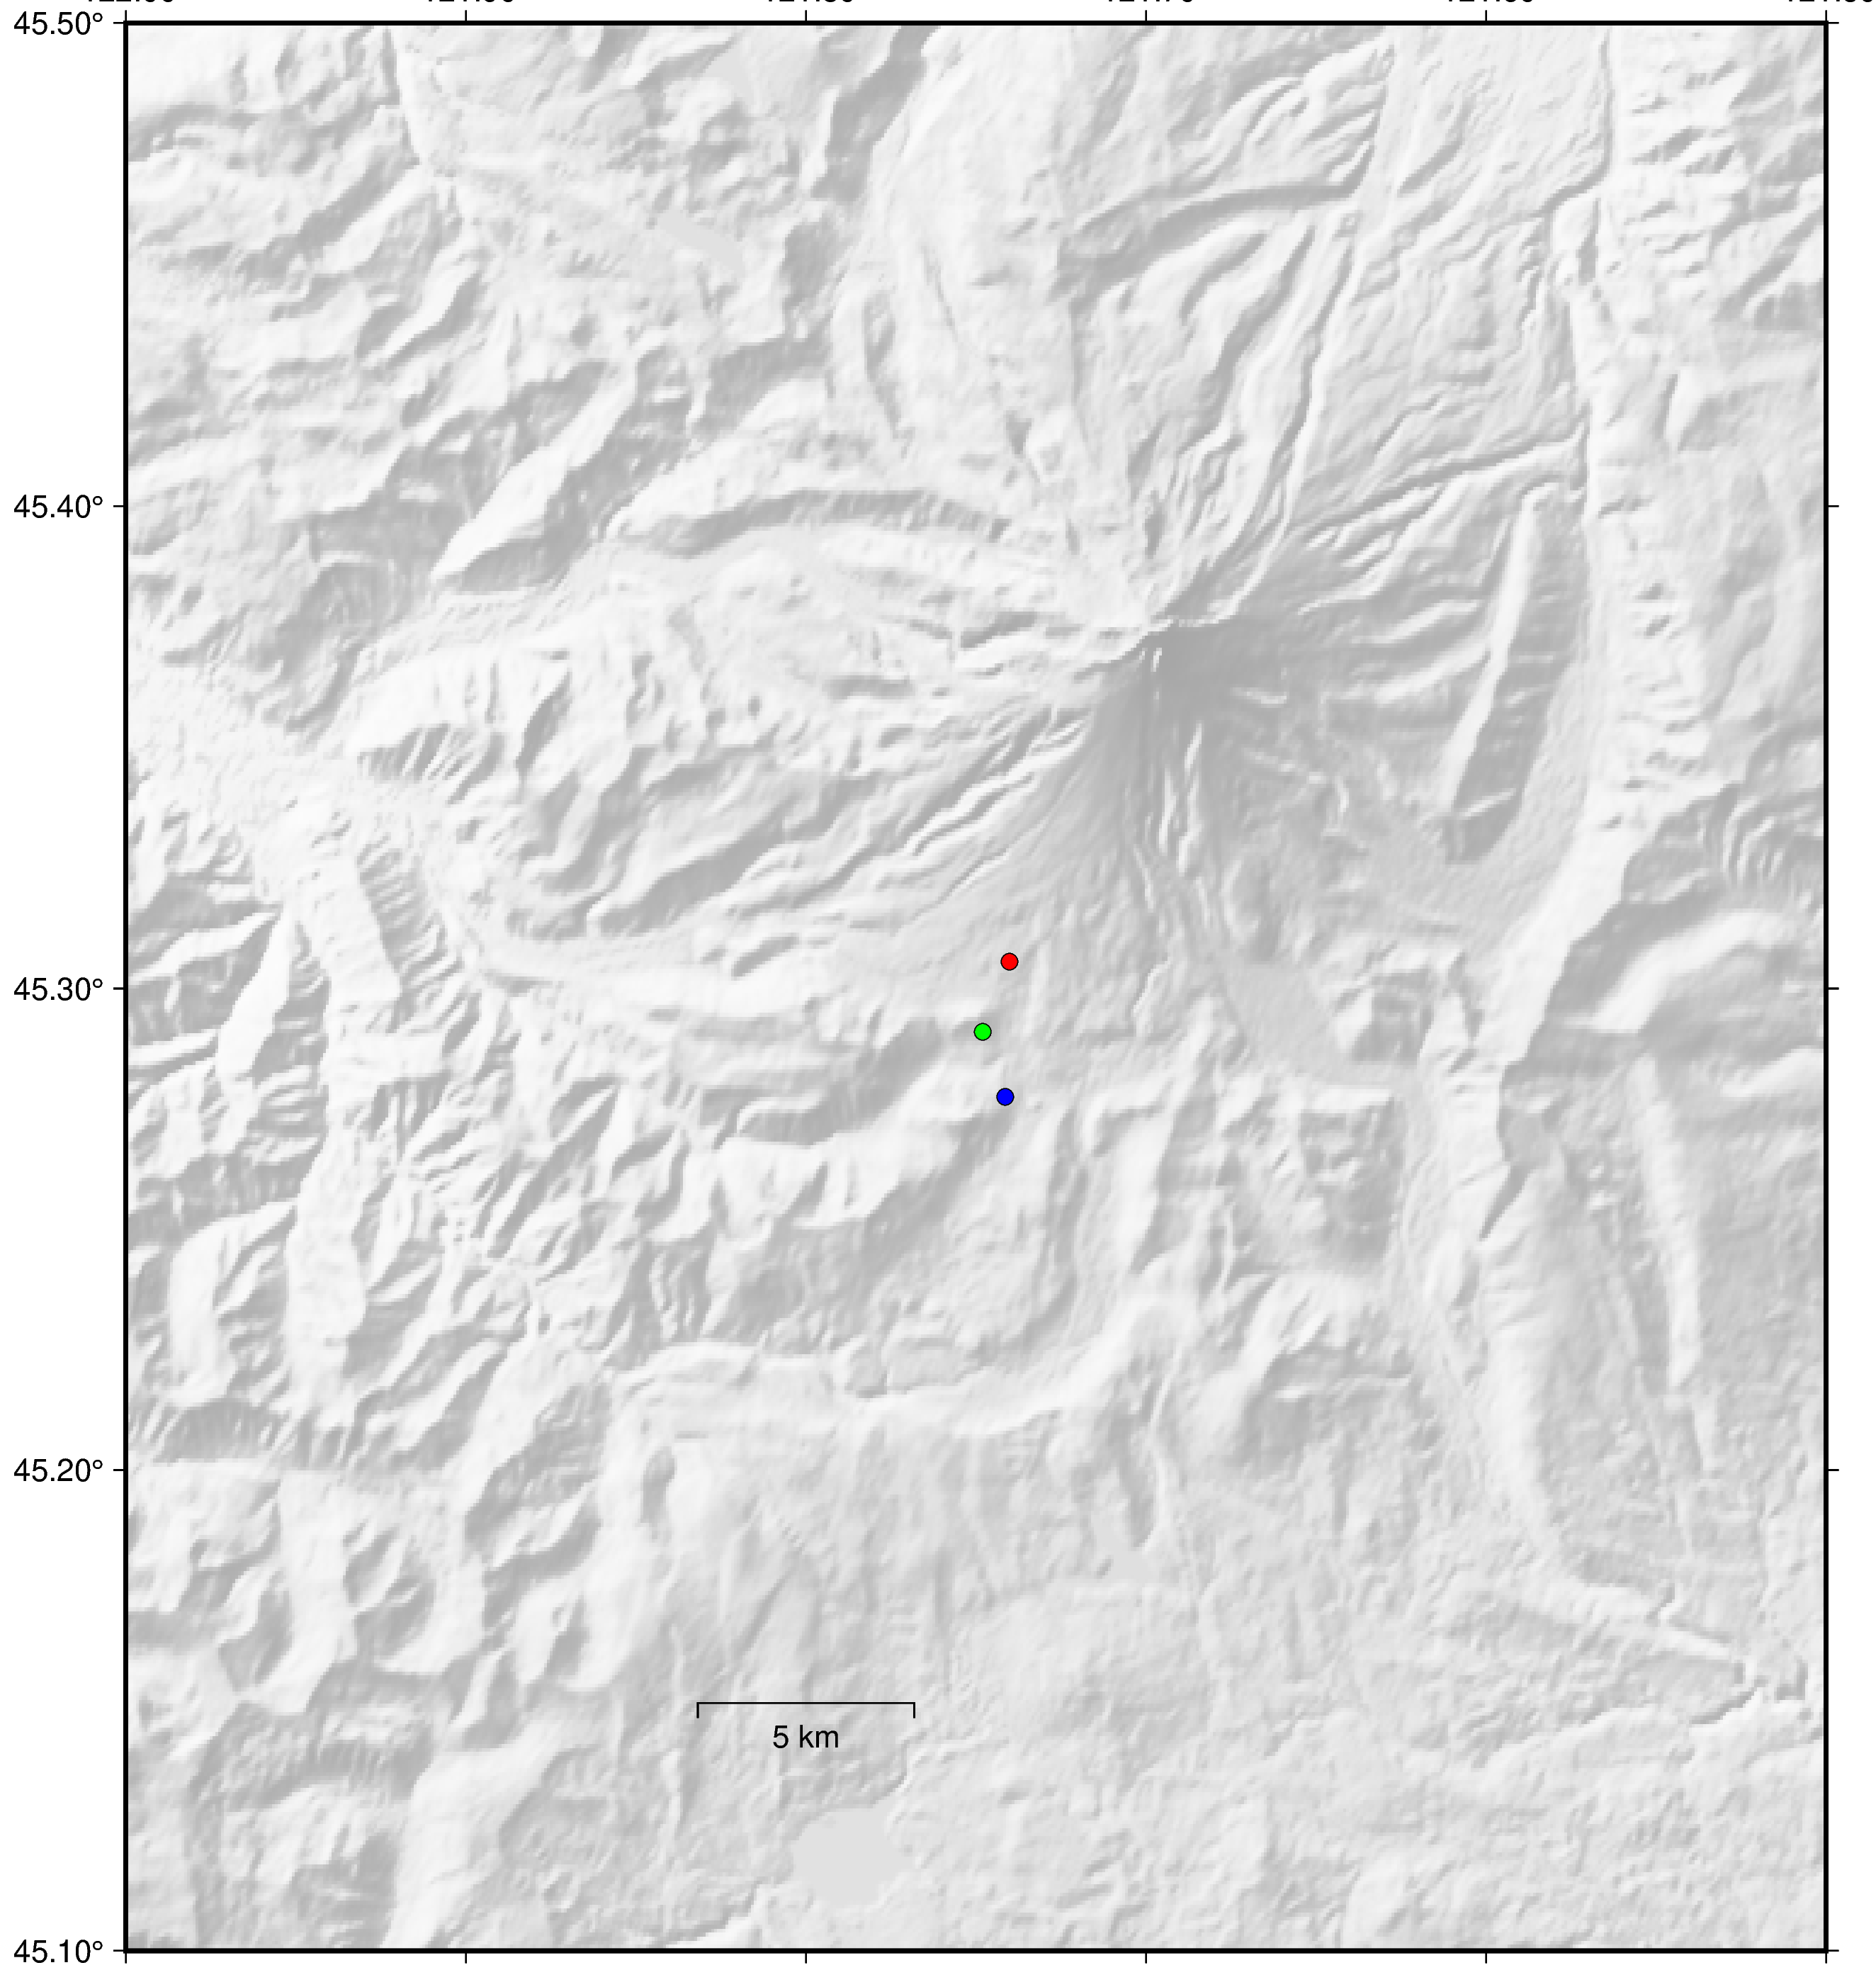

cluster 1
red (station delay) Lat [45.328609] Long [-121.635765]
blue (NO station delay) Lat [45.310044] Long [-121.630428]
green (Comcat) Lat [45.314] Long [-121.65]


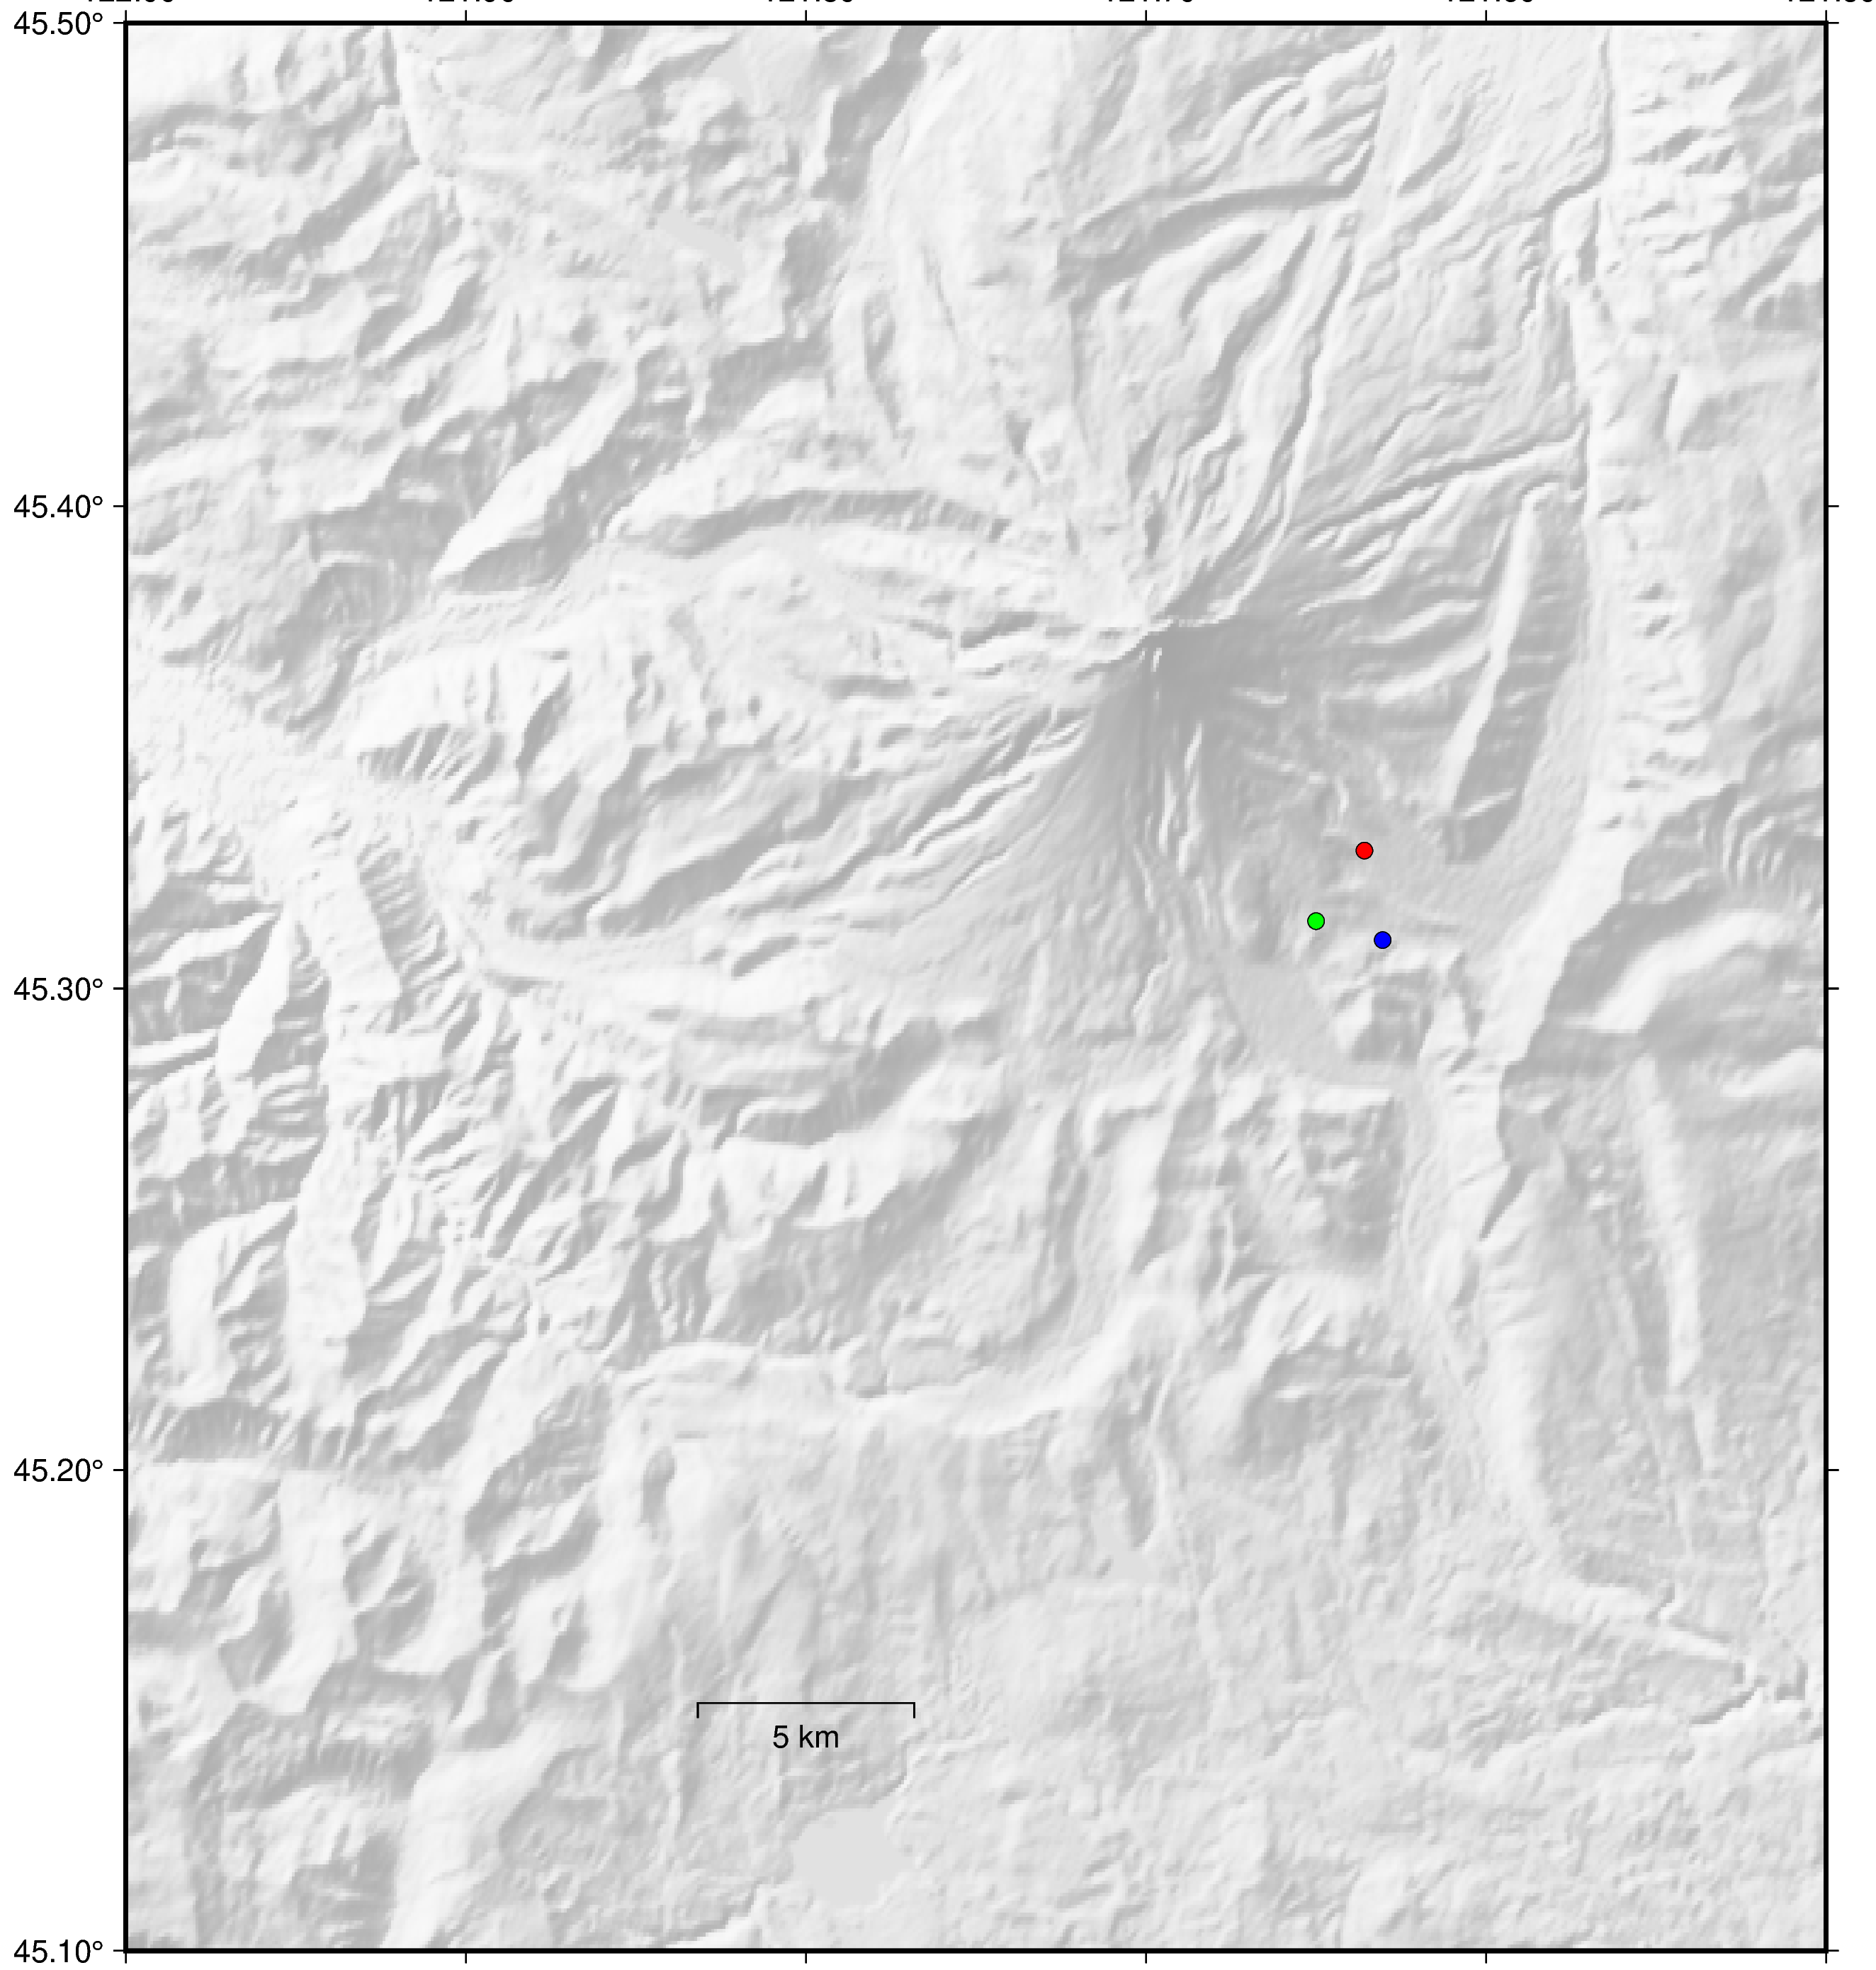

cluster 2
no comcat
cluster 3
no comcat
cluster 4
no comcat
cluster 5
no comcat
cluster 6
no comcat
cluster 7
red (station delay) Lat [45.954073] Long [-120.899326]
blue (NO station delay) Lat [45.699105] Long [-121.190679]
green (Comcat) Lat [45.293] Long [-121.733]


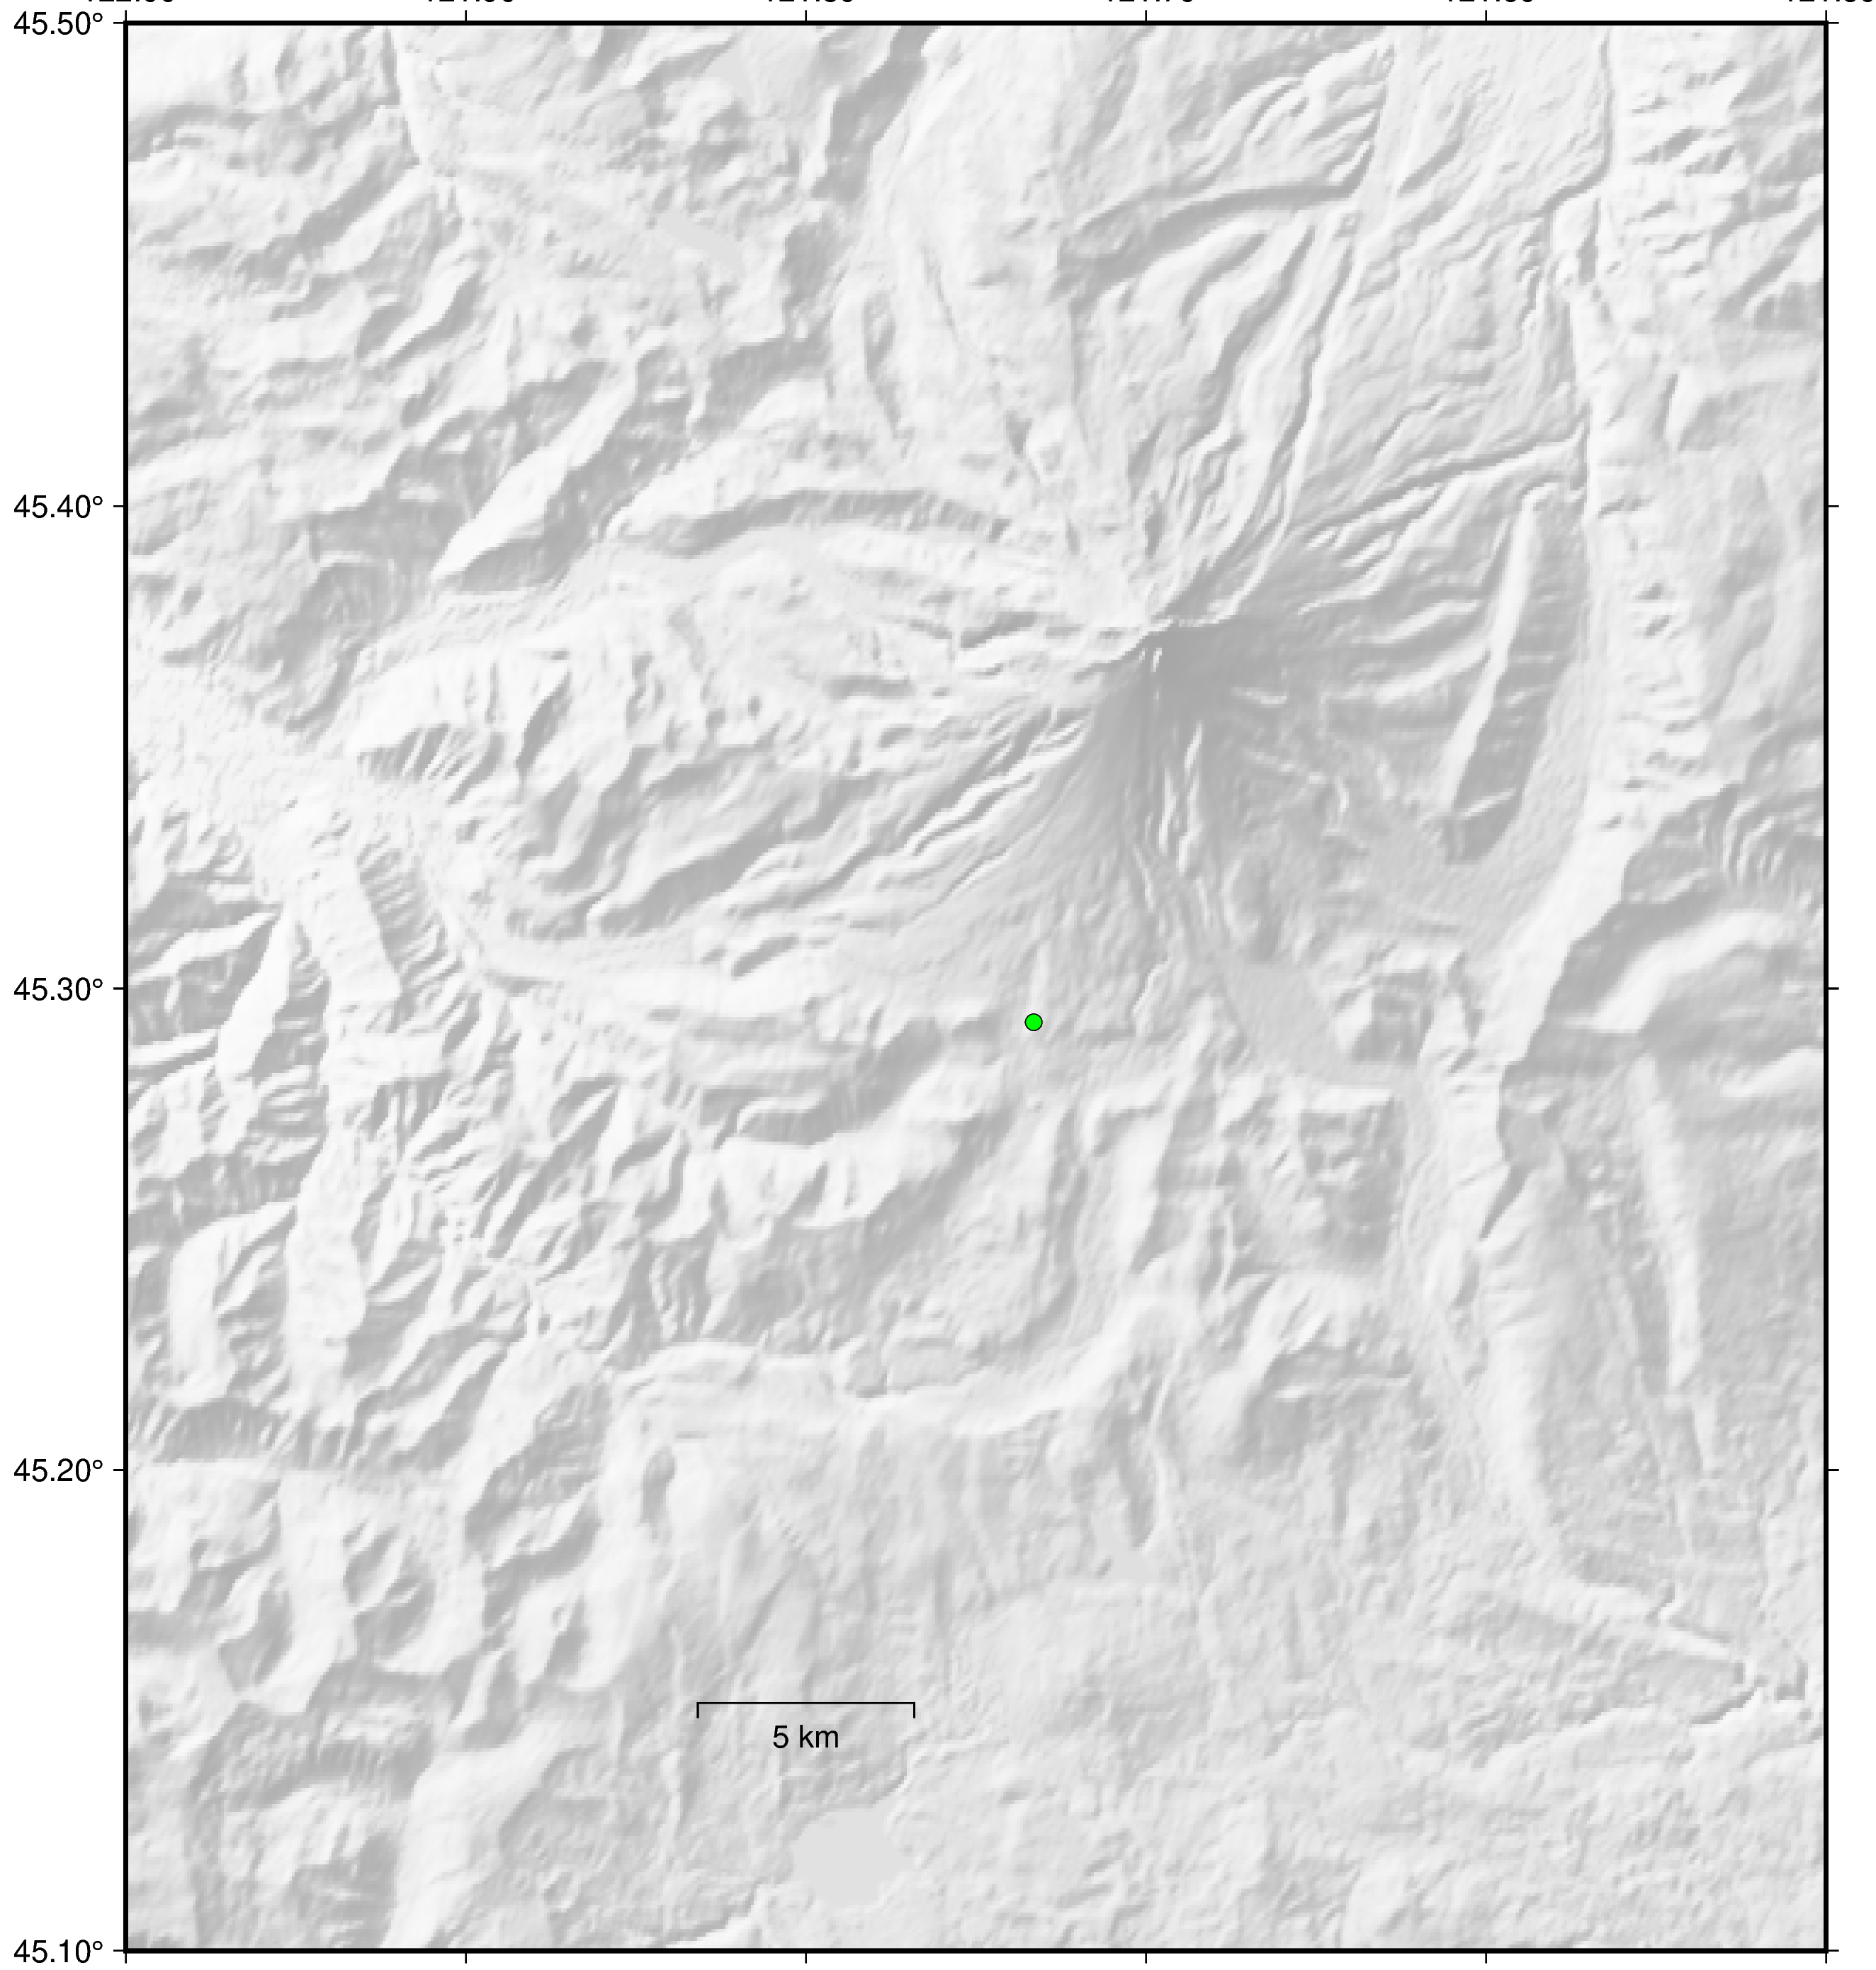

cluster 8
red (station delay) Lat [45.675411] Long [-121.788154]
blue (NO station delay) Lat [45.535966] Long [-121.679546]
green (Comcat) Lat [45.364] Long [-121.688]


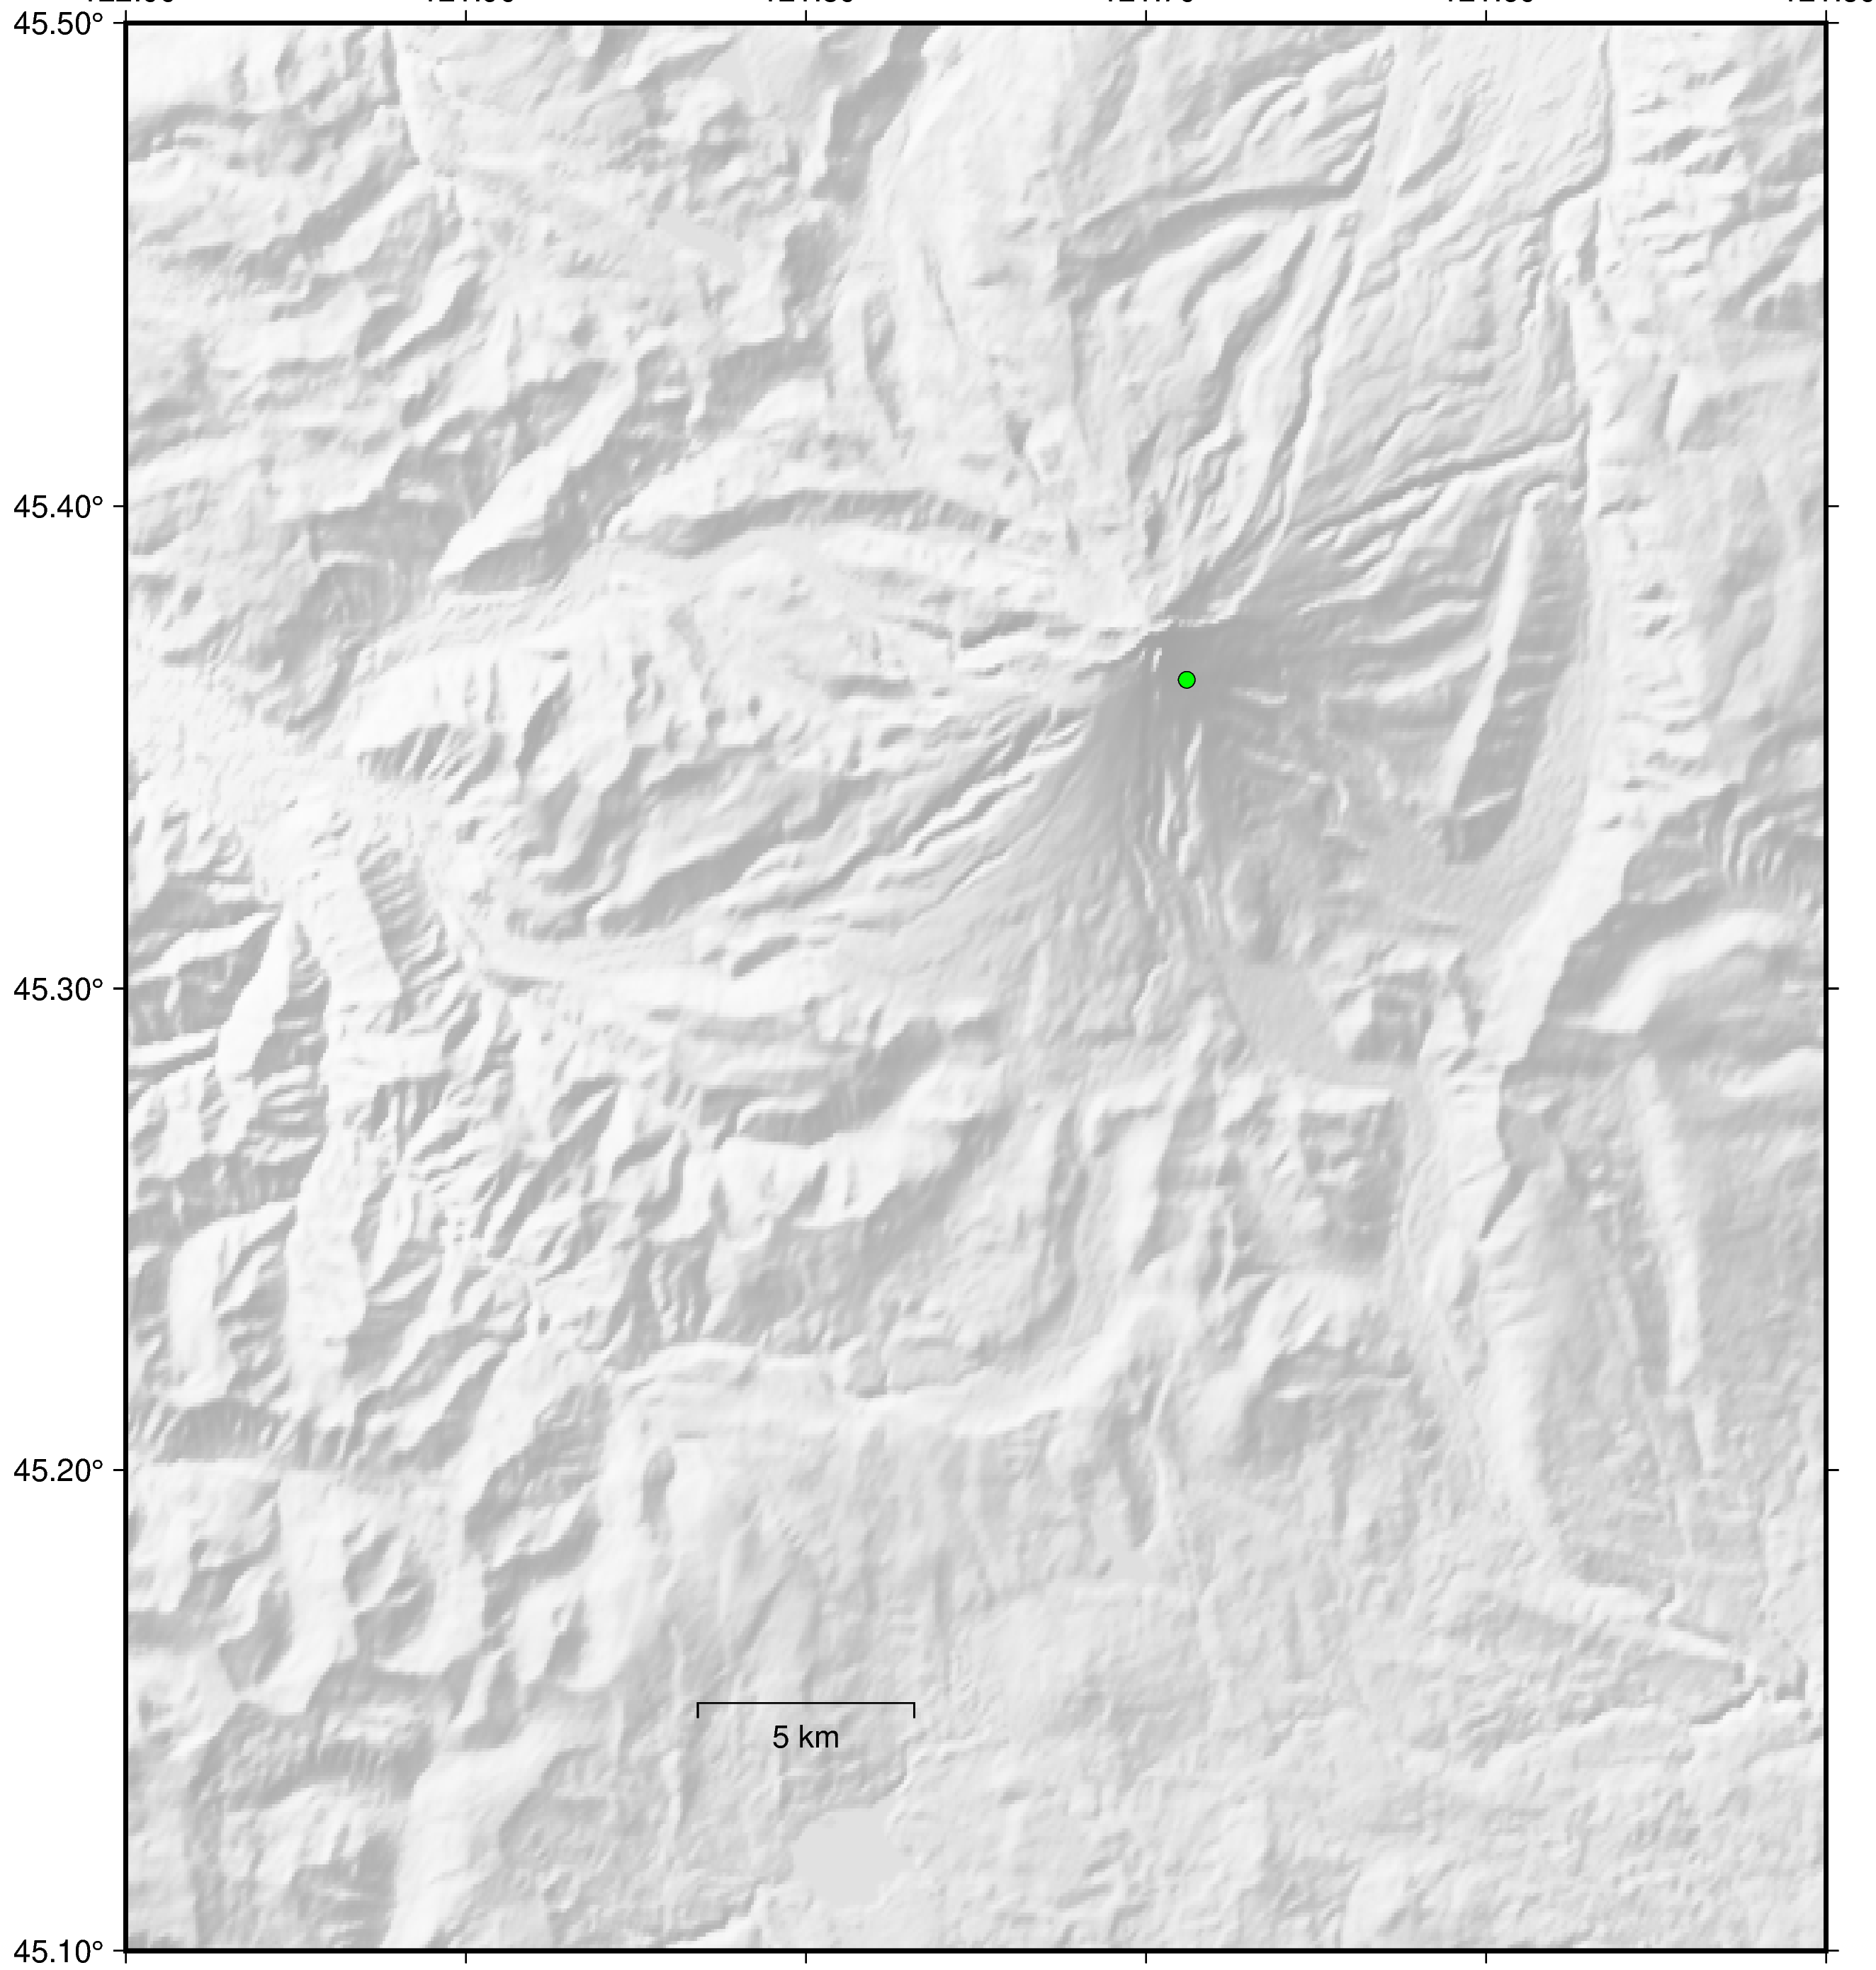

cluster 9
no comcat
cluster 10
red (station delay) Lat [45.29652] Long [-121.728107]
blue (NO station delay) Lat [45.264831] Long [-121.72459]
green (Comcat) Lat [45.365] Long [-121.701]


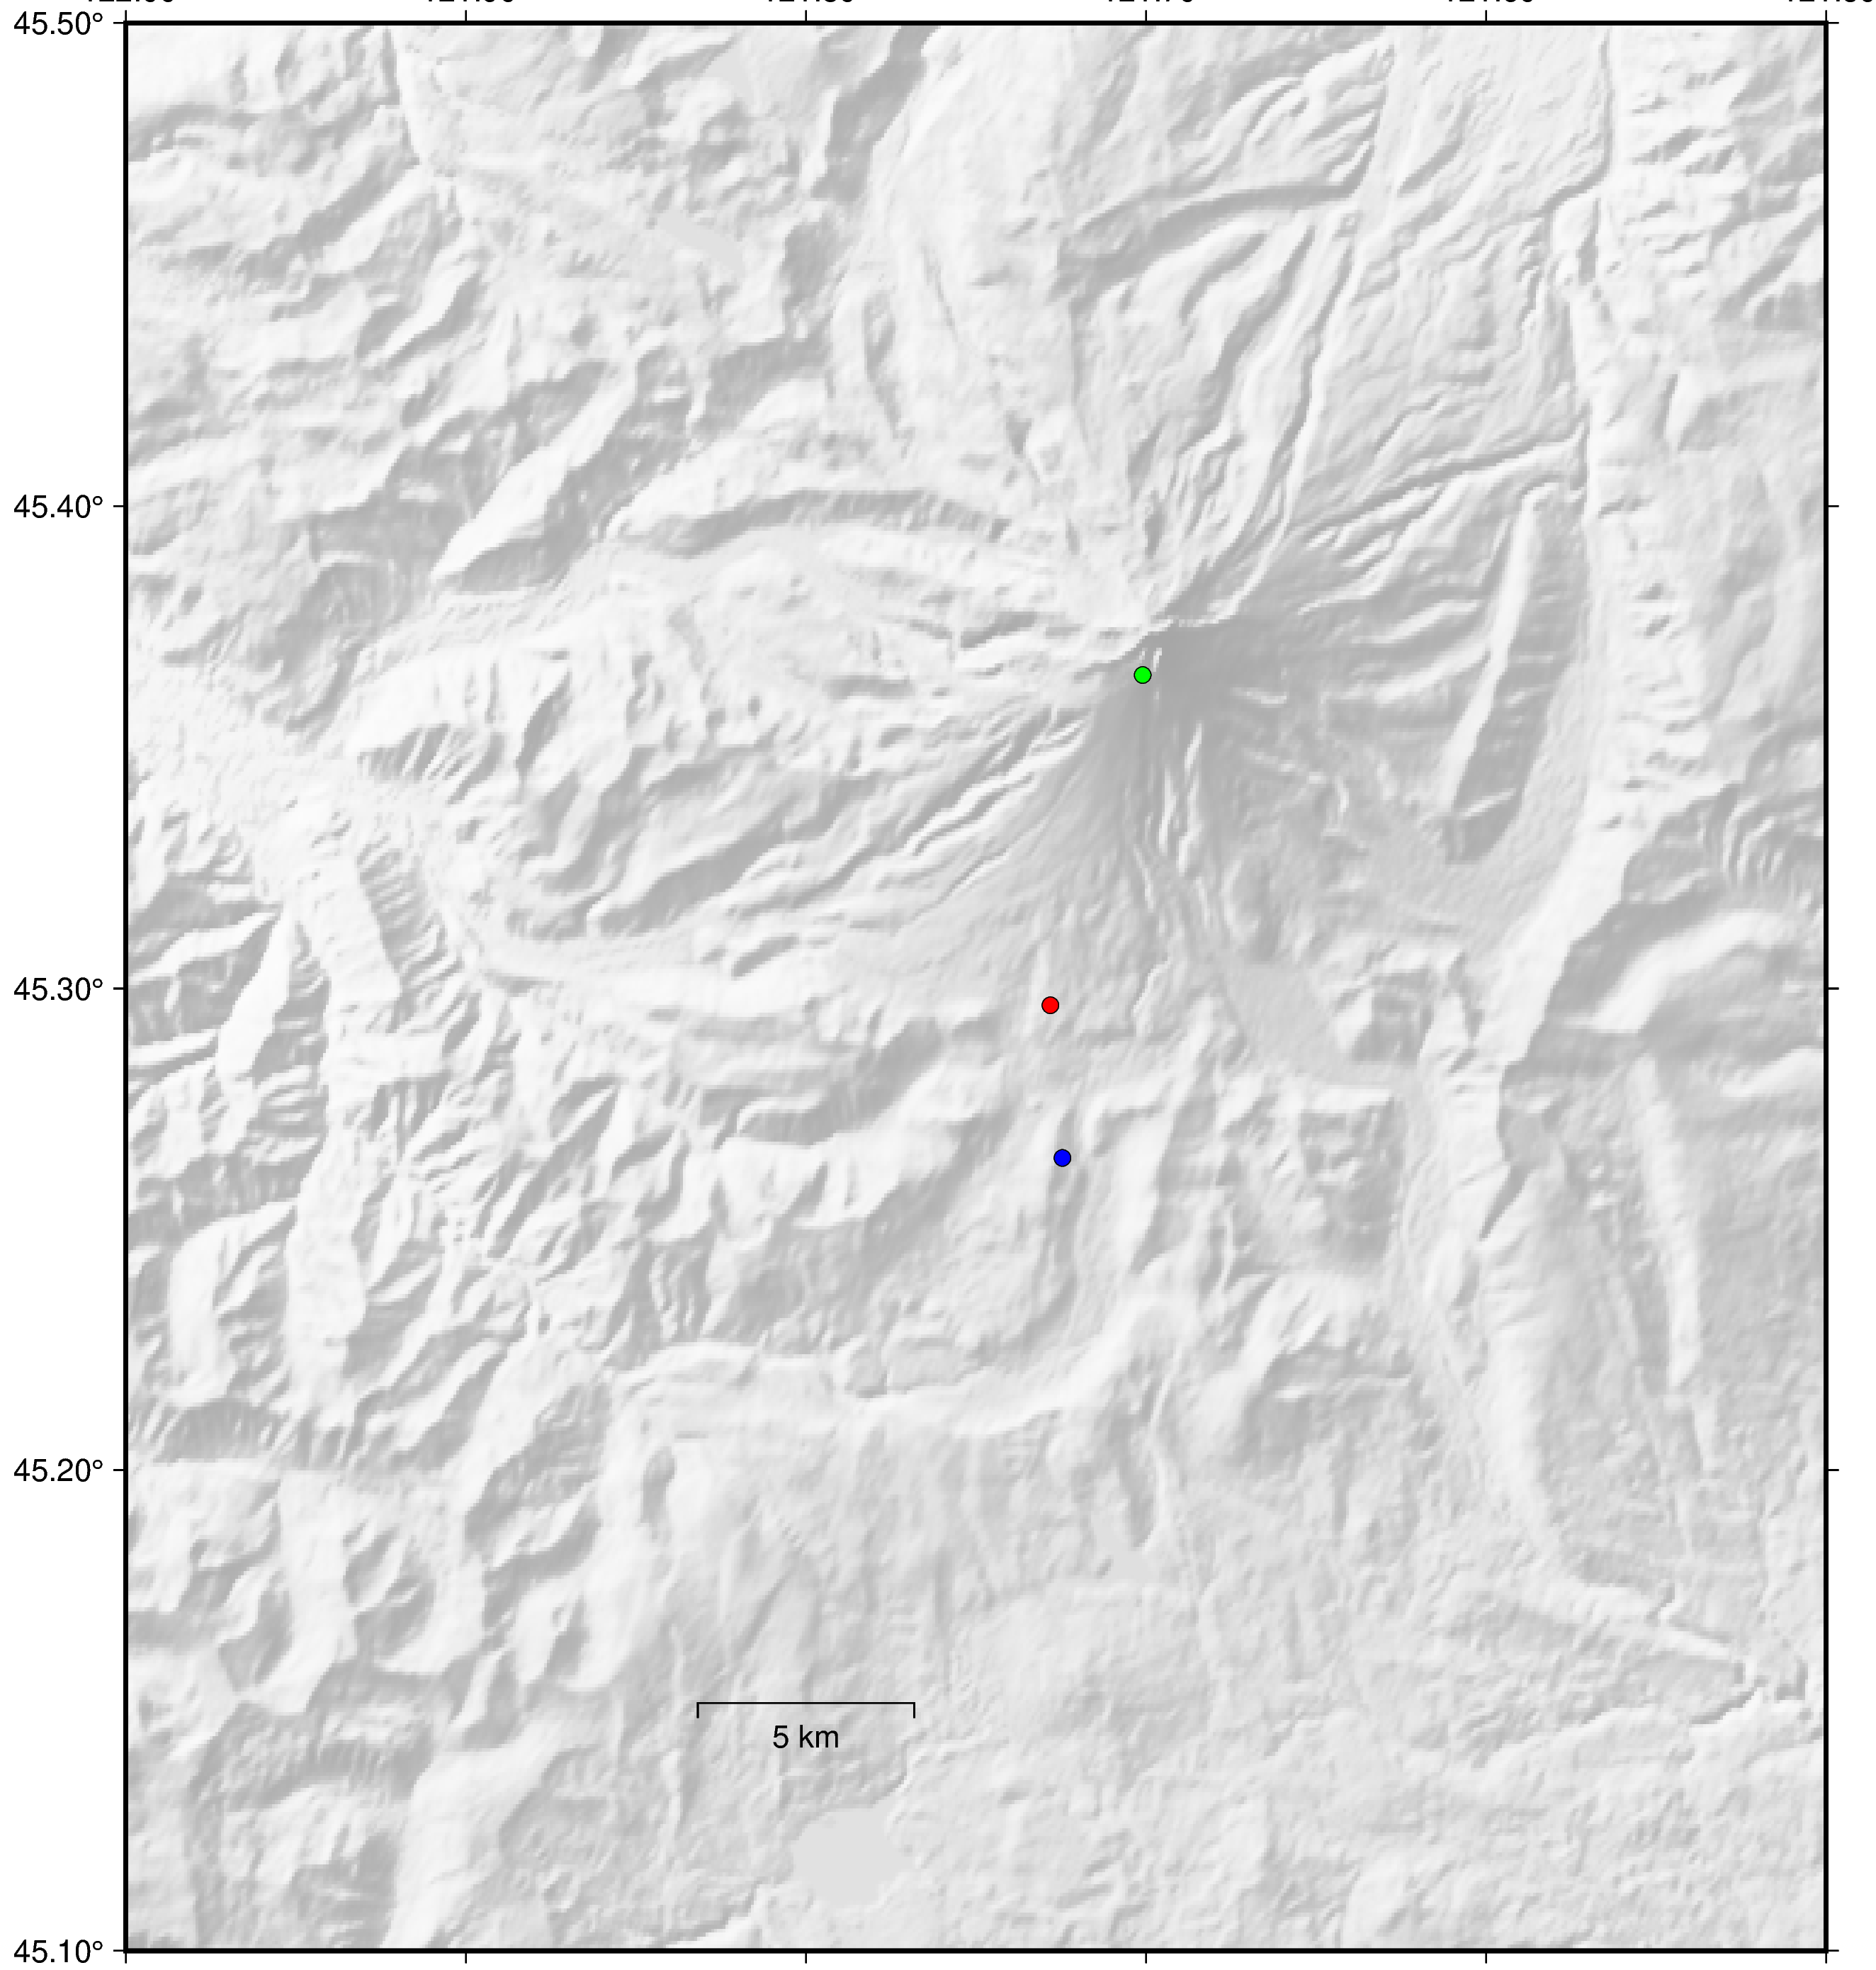

cluster 11
red (station delay) Lat [45.320543] Long [-121.666019]
blue (NO station delay) Lat [45.299319] Long [-121.659554]
green (Comcat) Lat [45.331] Long [-121.721]


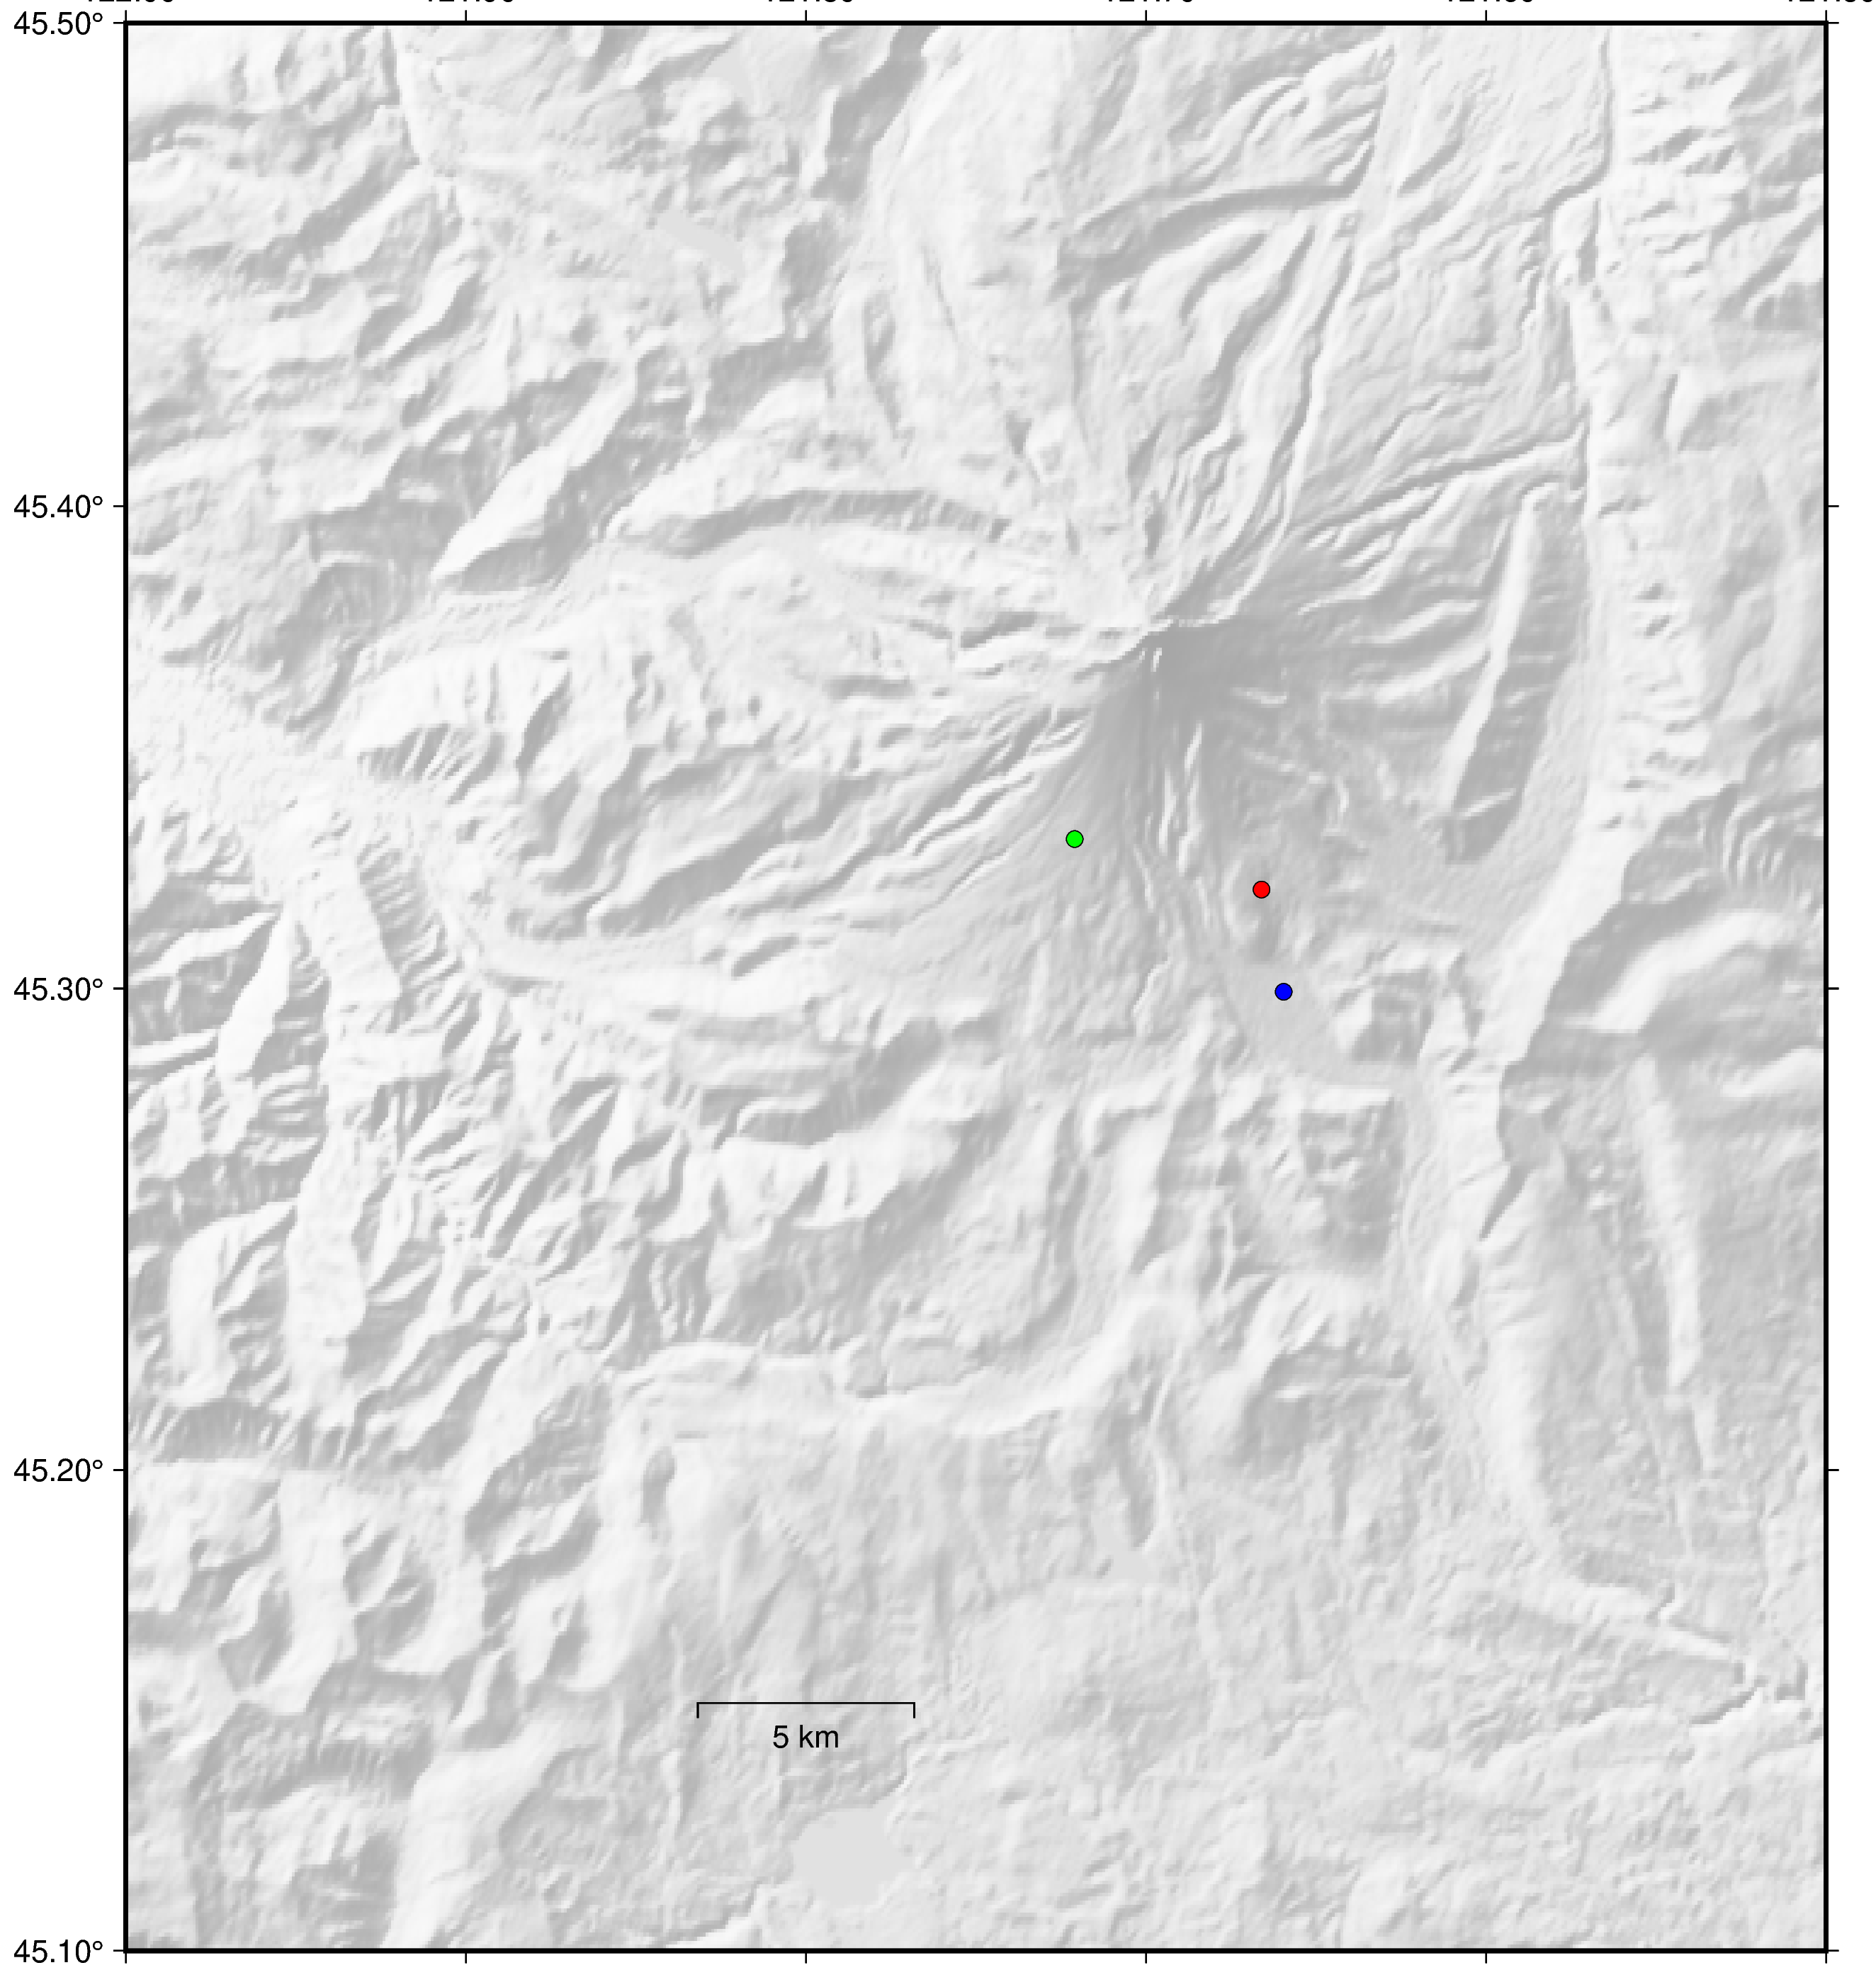

cluster 12
red (station delay) Lat [45.337061] Long [-121.715658]
blue (NO station delay) Lat [45.239883] Long [-121.633771]
green (Comcat) Lat [45.326] Long [-121.69]


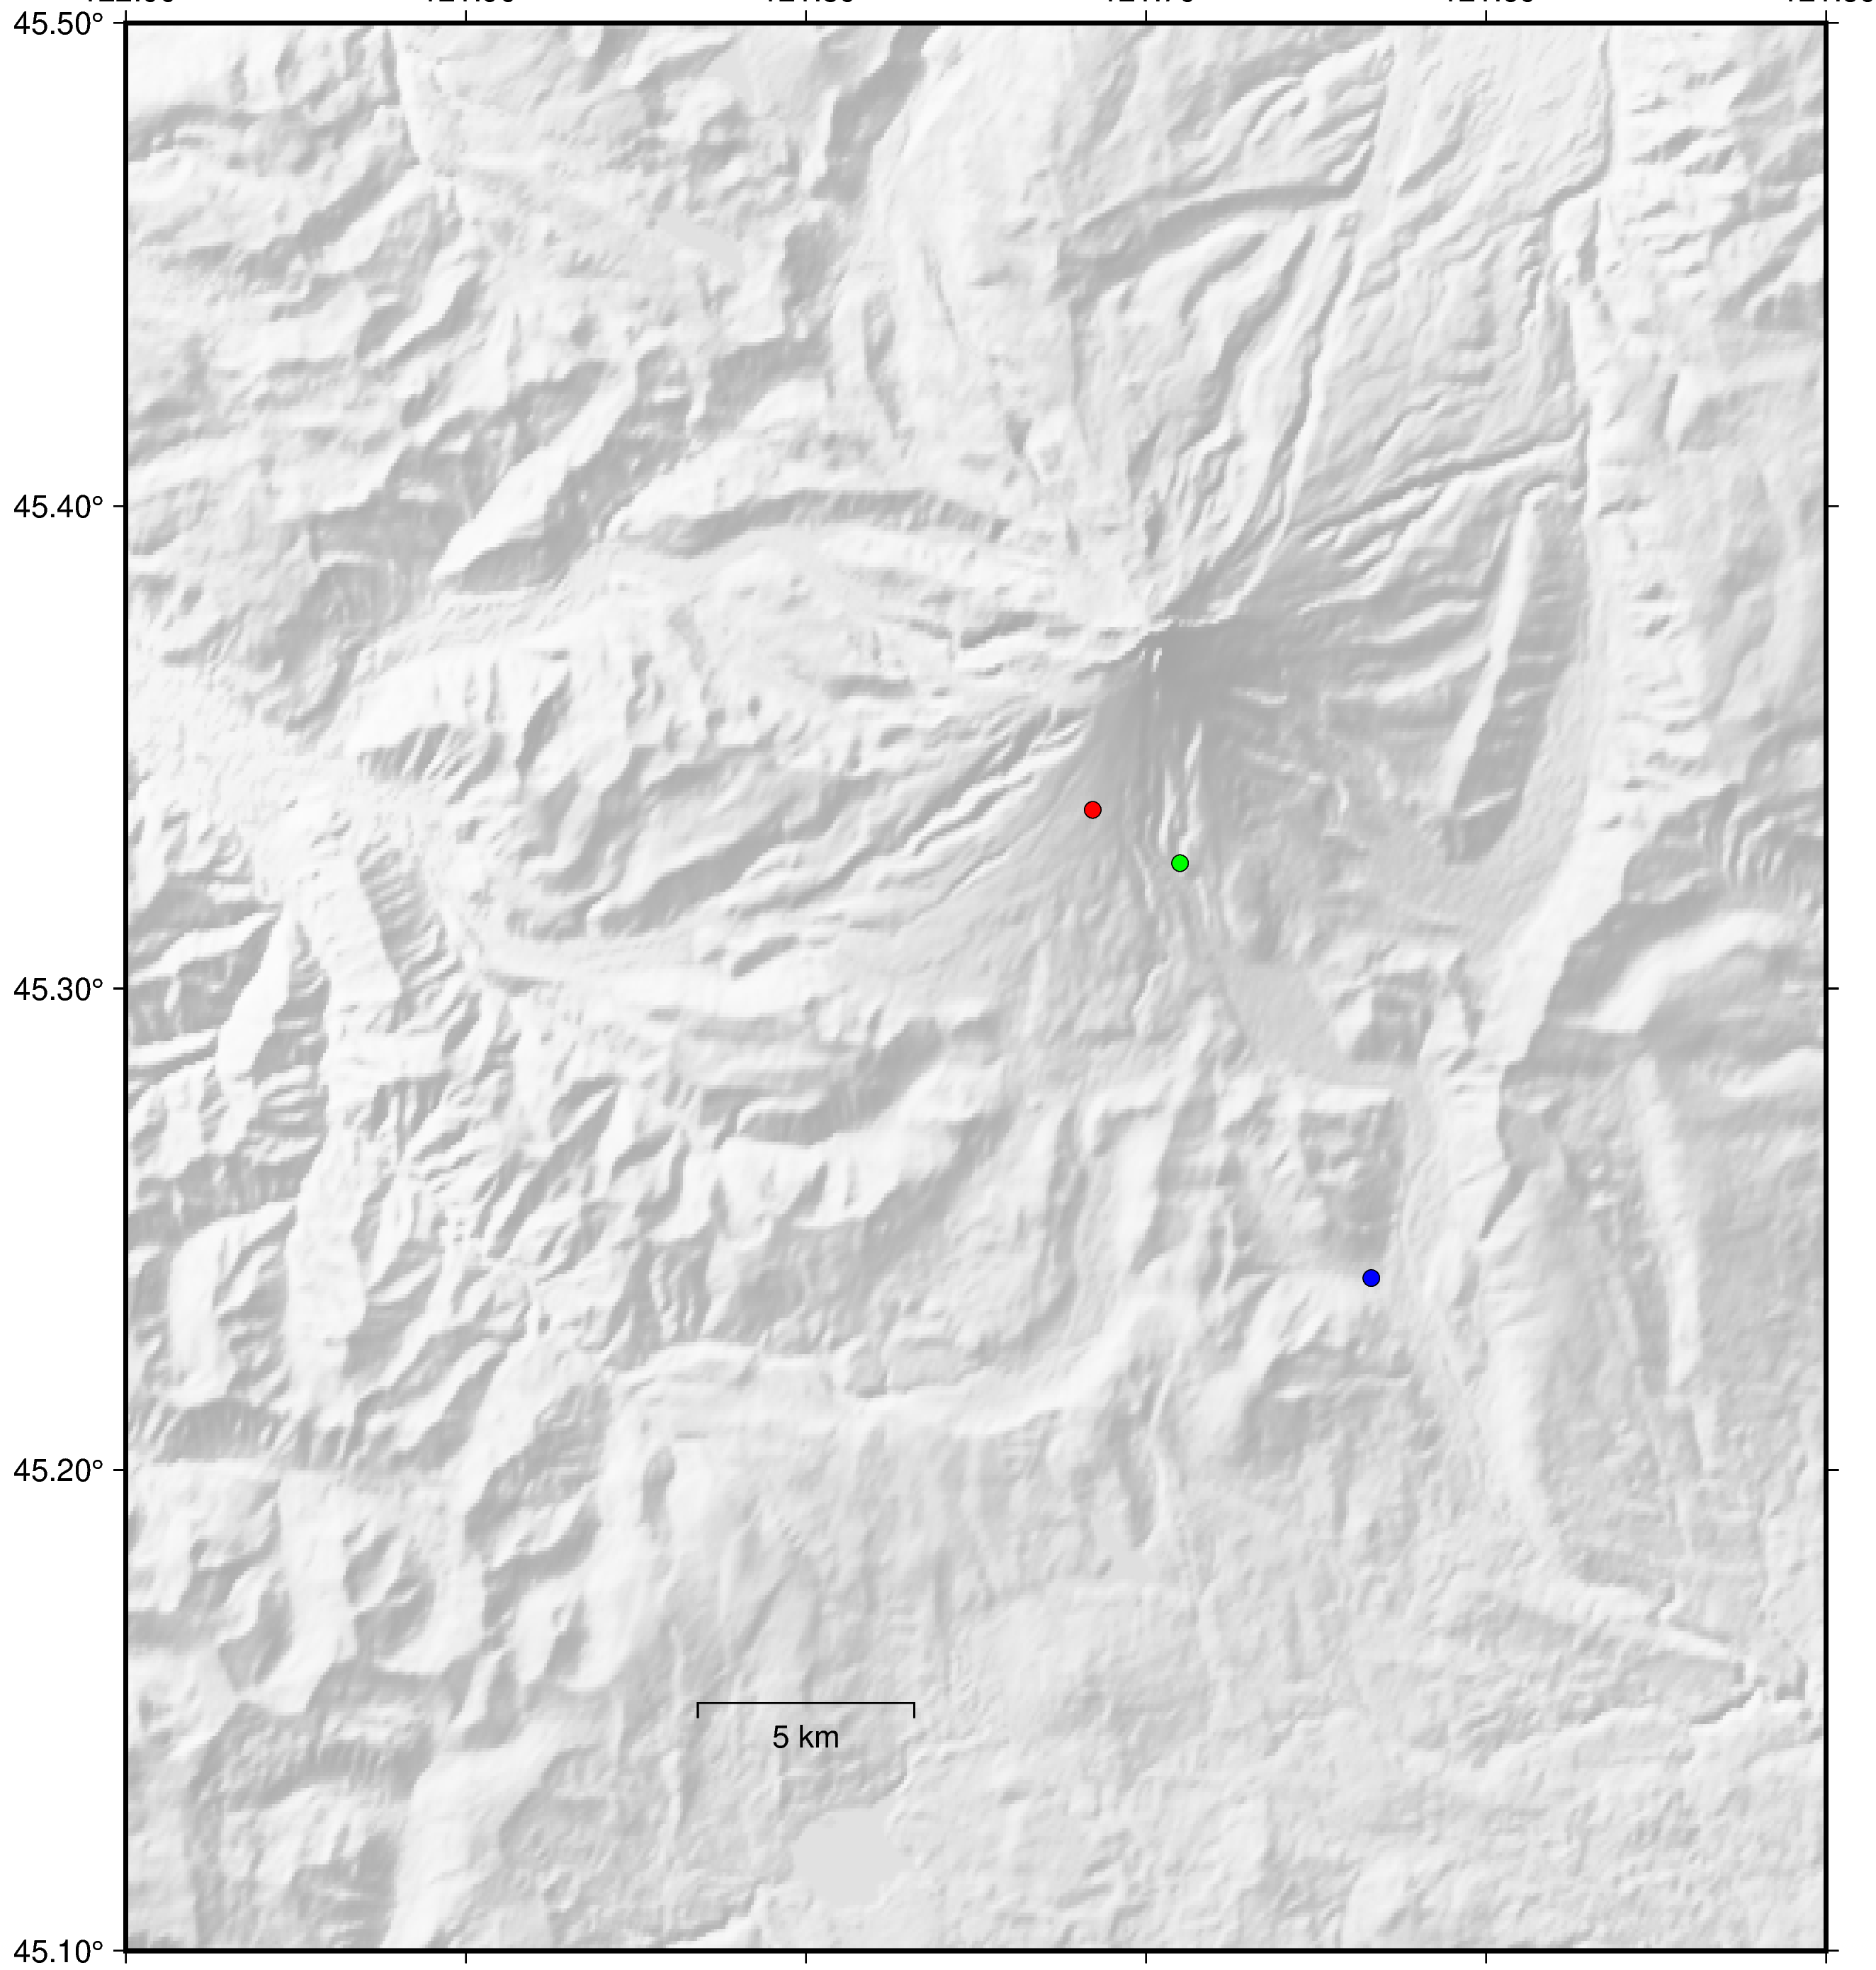

cluster 13
red (station delay) Lat [45.326805] Long [-121.615314]
blue (NO station delay) Lat [45.22392] Long [-121.627076]
green (Comcat) Lat [45.336] Long [-121.67]


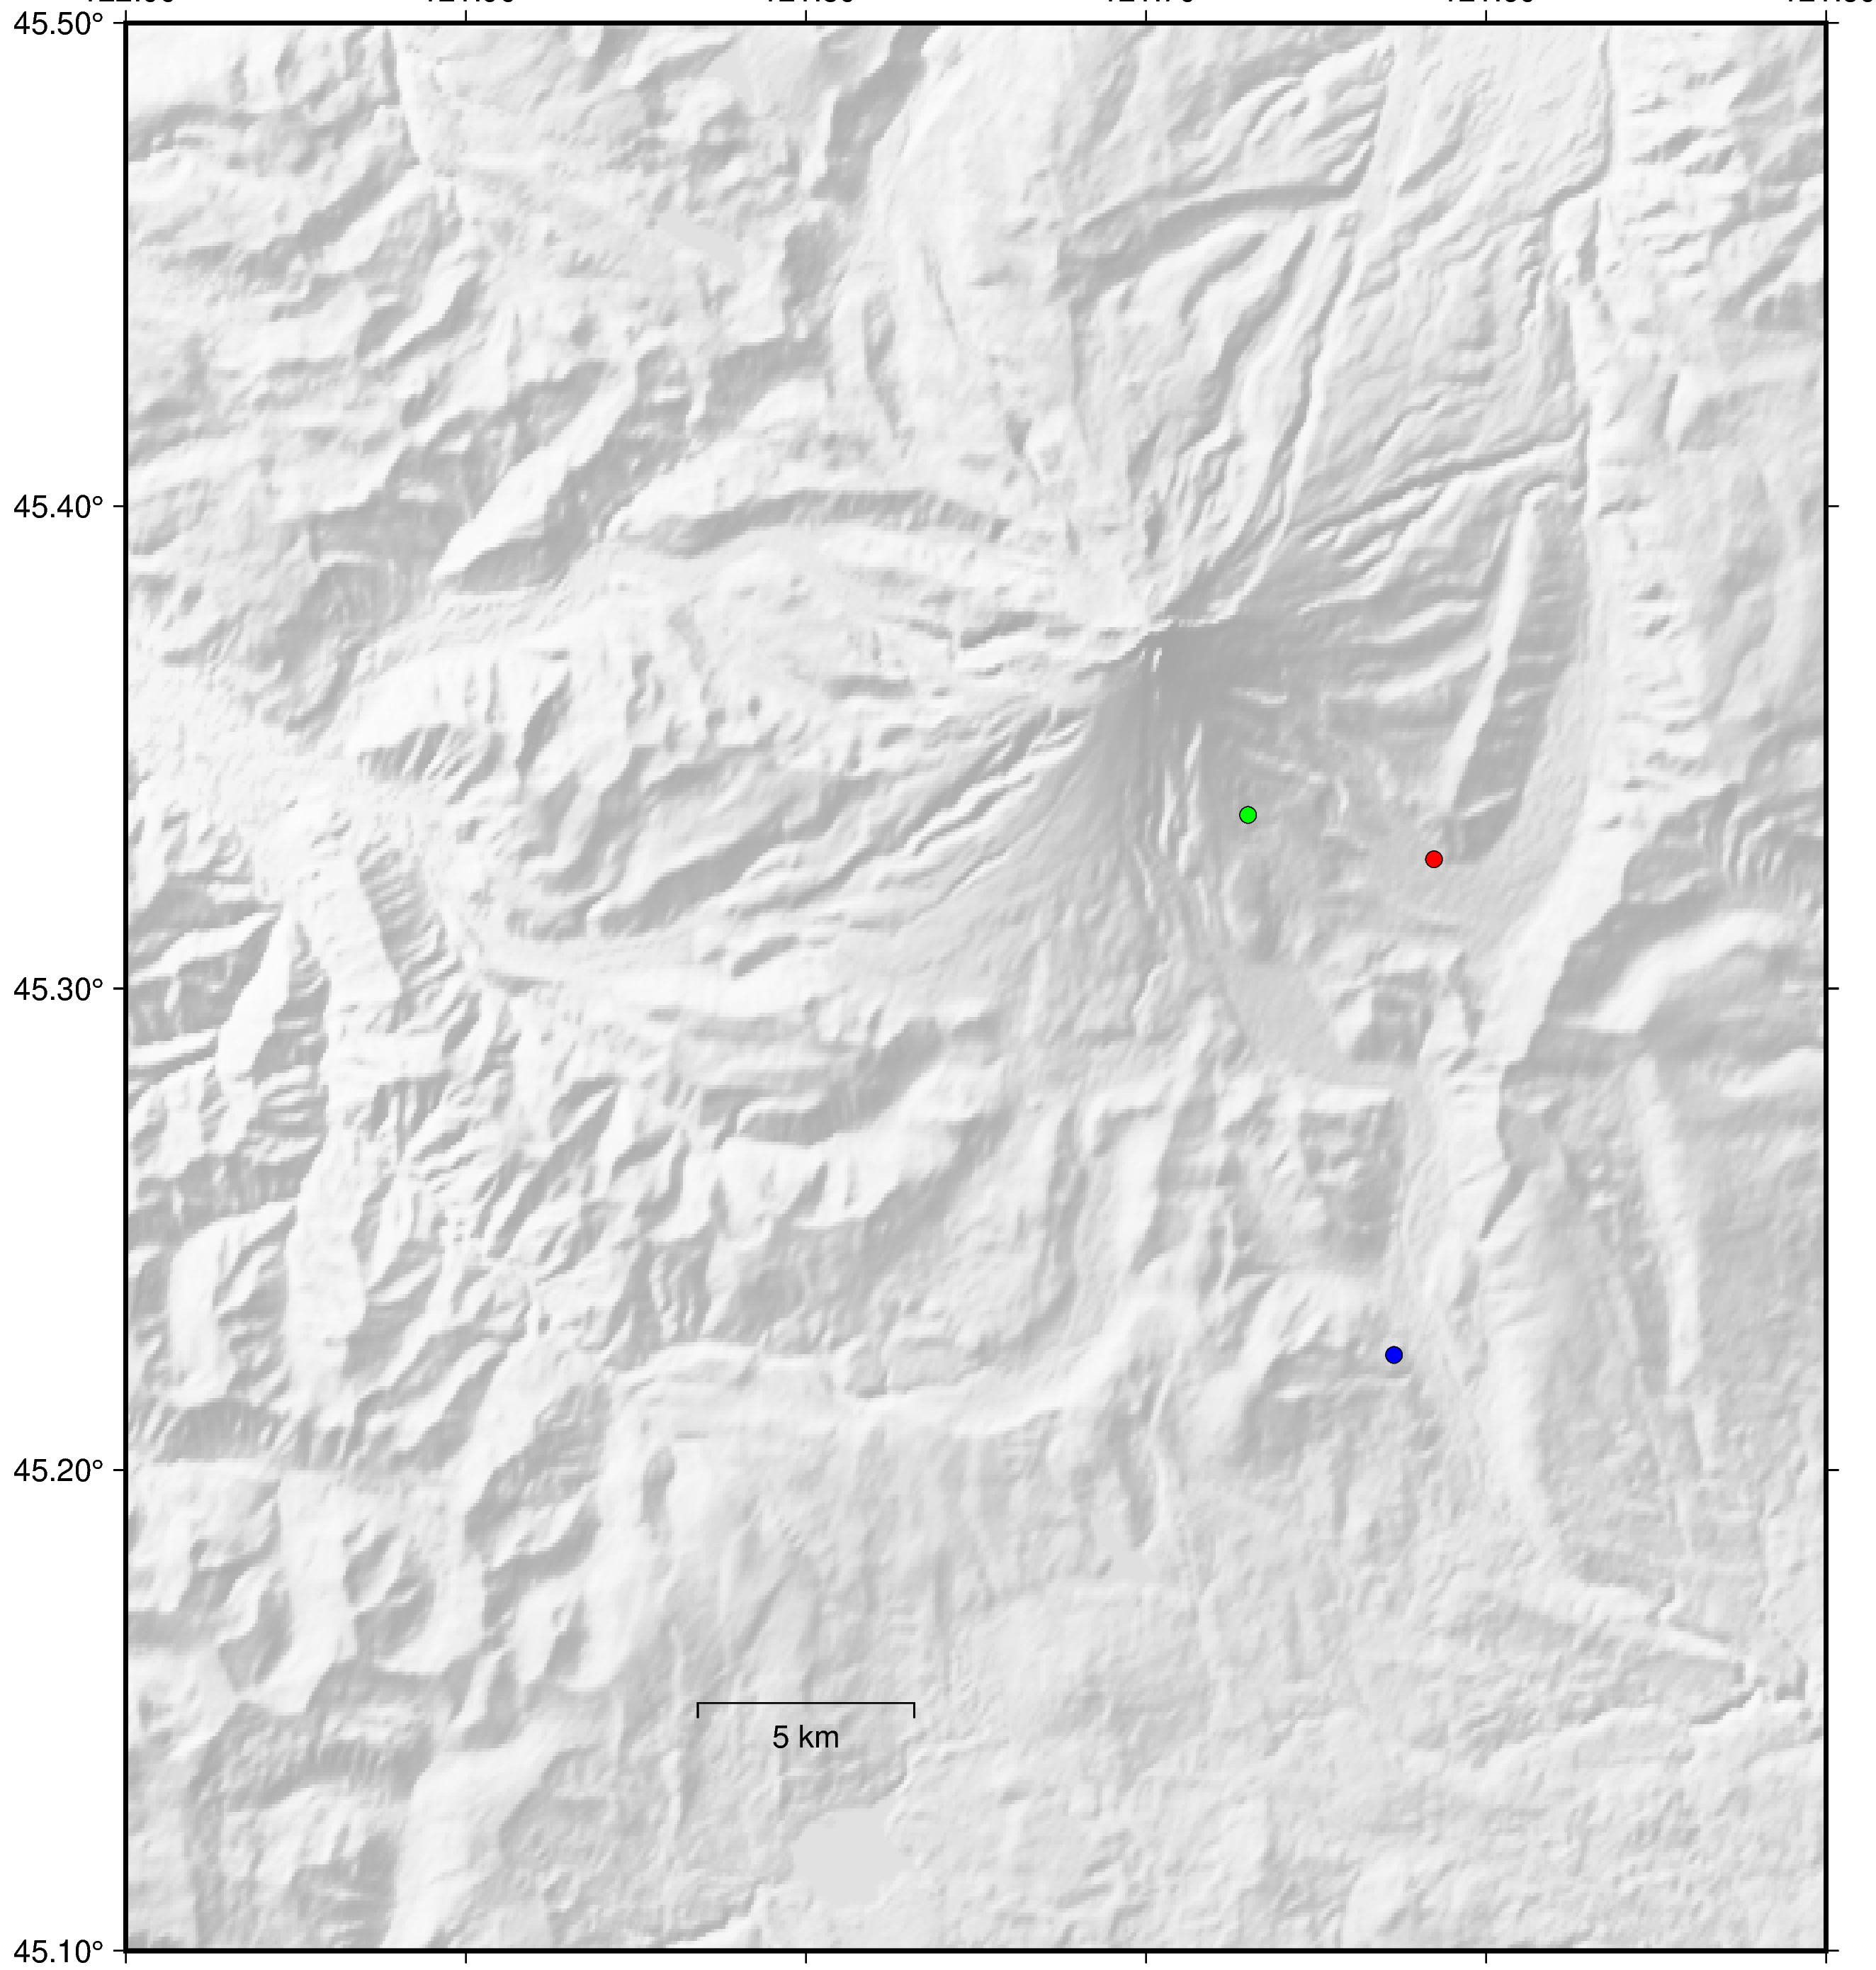

cluster 14
red (station delay) Lat [45.268618] Long [-122.154631]
blue (NO station delay) Lat [44.817388] Long [-122.941571]
green (Comcat) Lat [45.367] Long [-121.68]


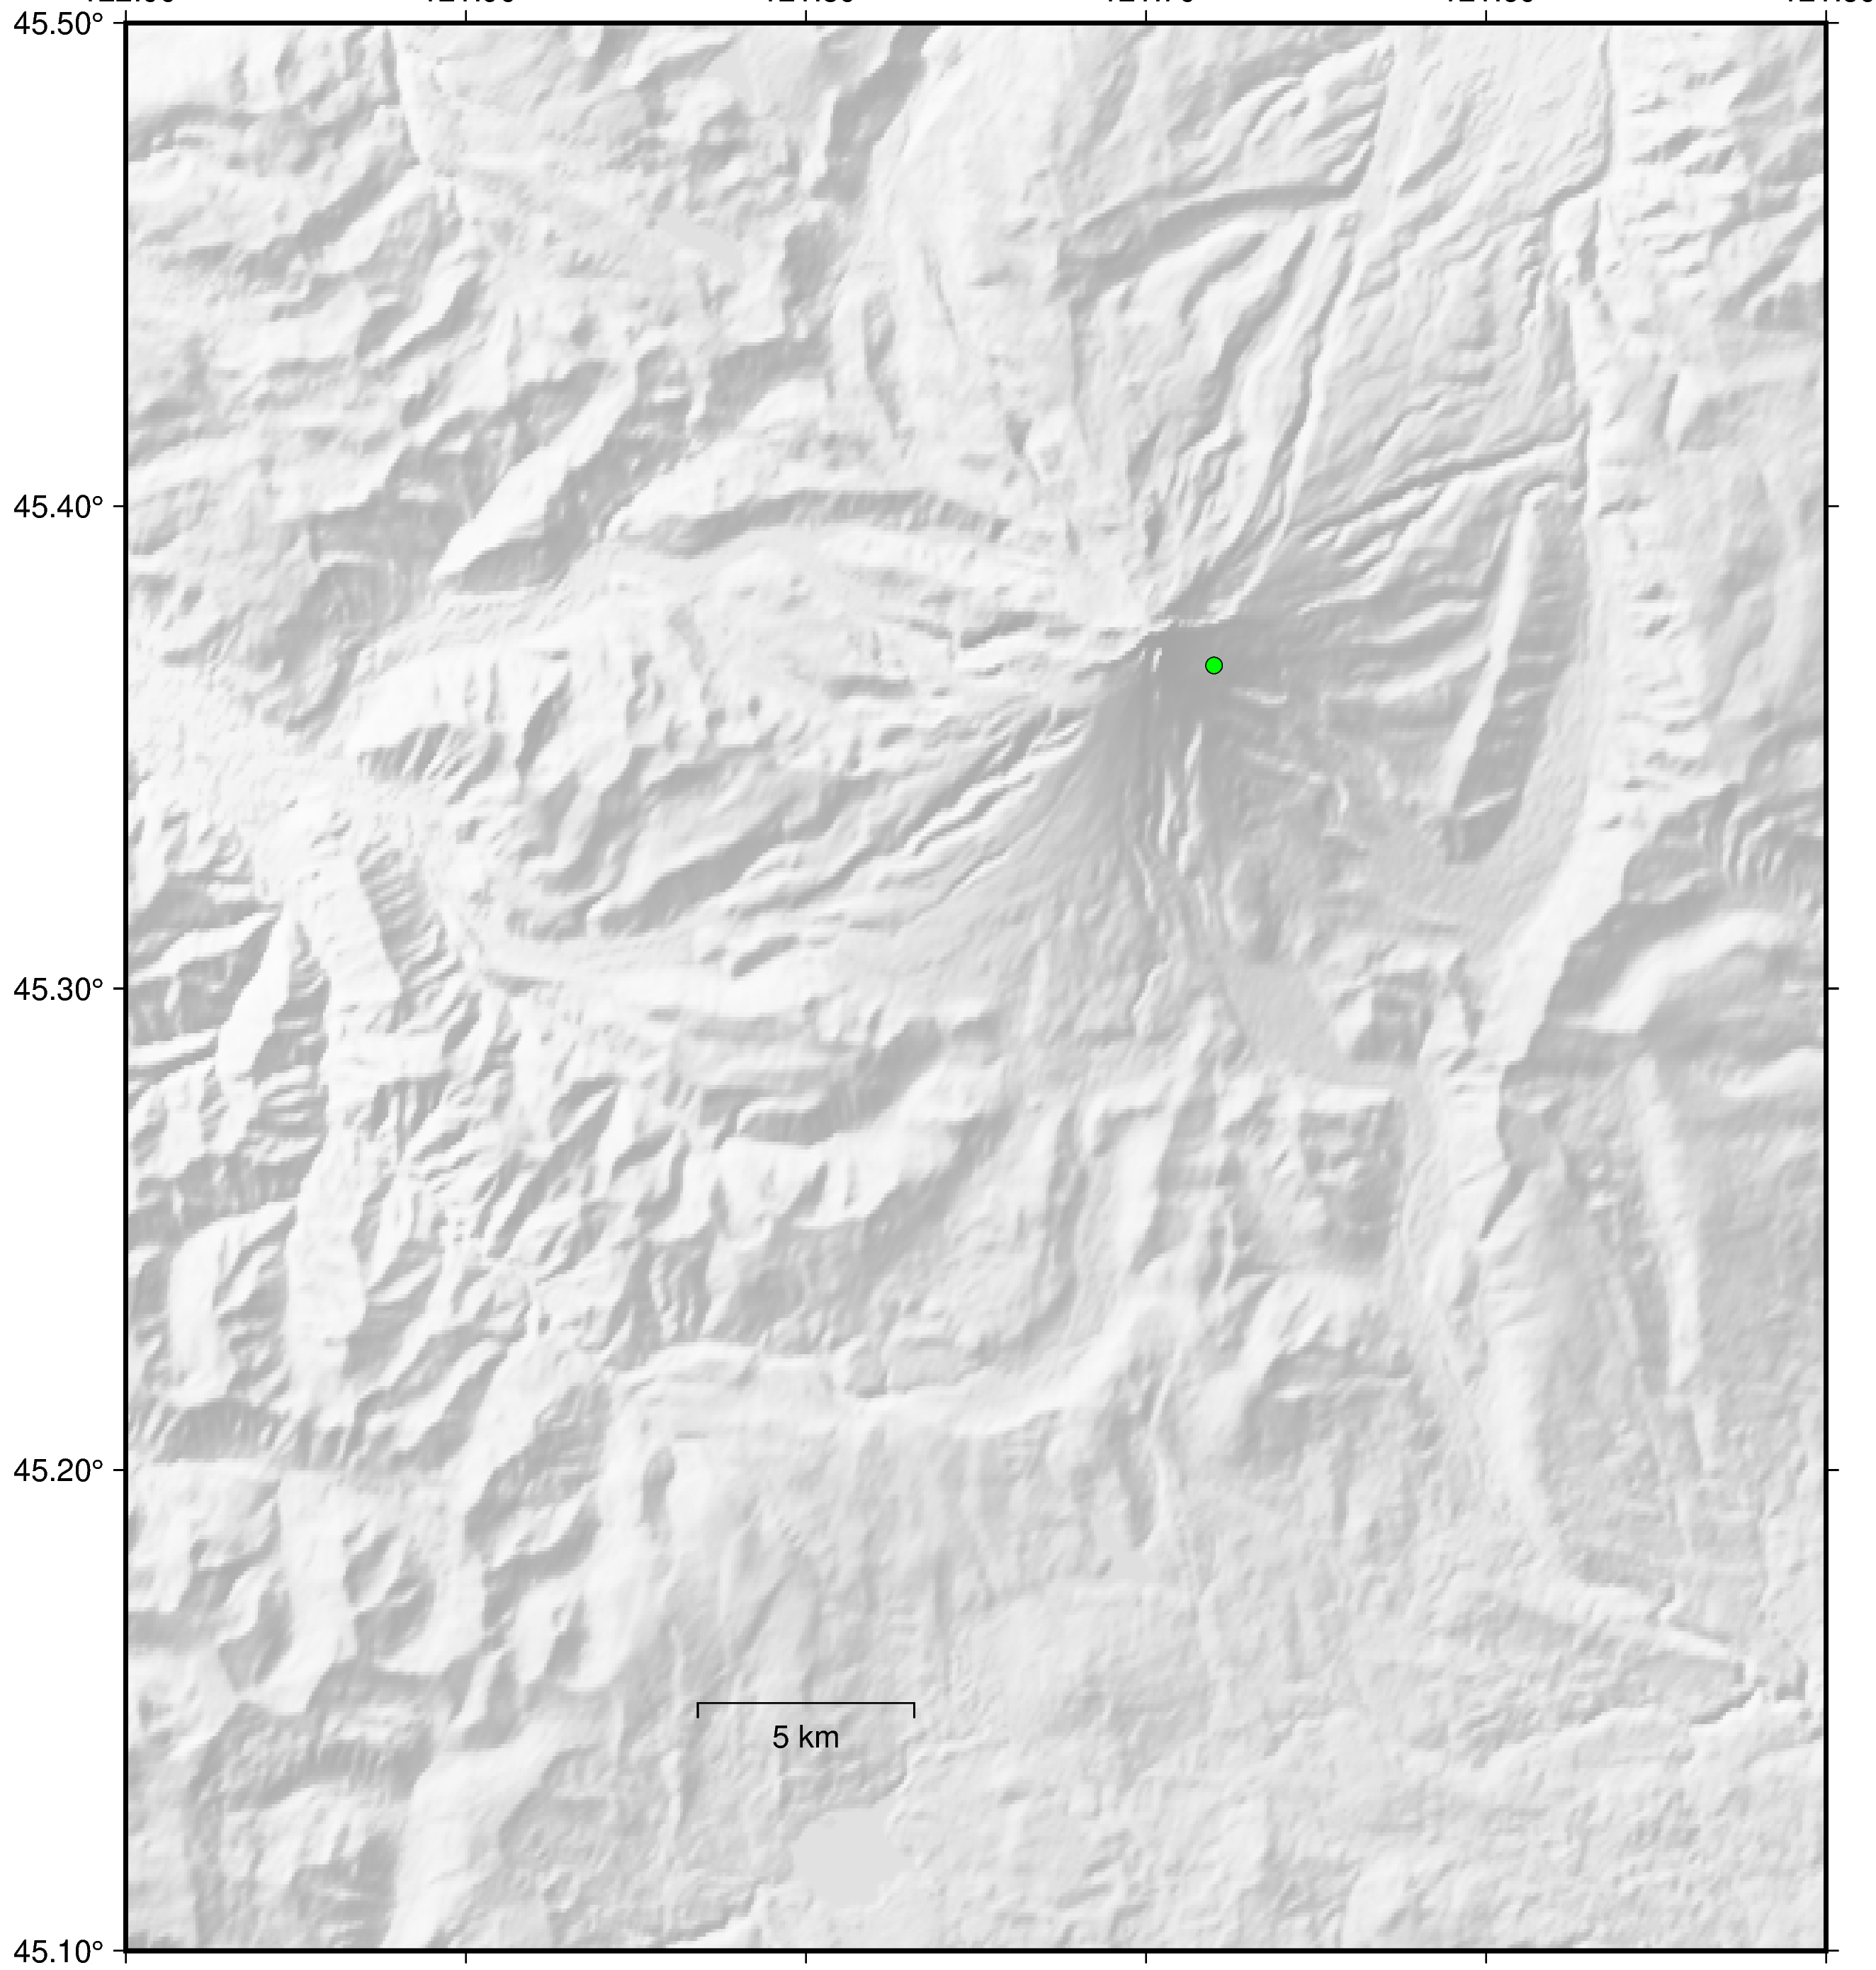

In [31]:
# comparing each cluster

# #####if you have pygmt installed, you can run this script. # 
### Point to the files and read them in using pandas vvvvv

nsd = pd.read_csv('nick_hood_NSD.RELOC_CLEANED') #locations that didn't use station delays. 
sd = pd.read_csv('nick_hood_SD.RELOC_CLEANED') # locations that did use station delays. 

###  This will take care of the rest of the basic plotting. 

# cl=160
for cl in range(0,15):
    cl_idx = list(np.unique(pick_df["Cluster_ID"].values.tolist())).index(cl)#index of cluster in list
    print('cluster',cl)
    if cl not in cc_df["Cluster_ID"].values.tolist():
        print('no comcat')
        continue
        
    print(f'red (station delay) Lat {sd.iloc[[cl_idx]]["mLat"].values.tolist()} Long {sd.iloc[[cl_idx]]["mLong"].values.tolist()}')
    print(f'blue (NO station delay) Lat {nsd.iloc[[cl_idx]]["mLat"].values.tolist()} Long {nsd.iloc[[cl_idx]]["mLong"].values.tolist()}')
    print(f'green (Comcat) Lat {cc_df[cc_df["Cluster_ID"]==cl]["Latitude"].values.tolist()} Long {cc_df[cc_df["Cluster_ID"]==cl]["Longitude"].values.tolist()}')

    fig=pygmt.Figure()
    pygmt.config(MAP_FRAME_TYPE="plain")
    pygmt.config(FORMAT_GEO_MAP="ddd.xx")
    r=[-122,-121.5,45.1,45.5]
    topo_data = '@earth_relief_03s' #30 arc second global relief (SRTM15+V2.1 @ 1.0 km)
    colormap = pygmt.makecpt(
        cmap="grayC",
        series='0/5000/100',
        continuous=True)
    fig.grdimage(
        grid=topo_data,
        region=r,
        projection='M8i',
        shading = True,
        cmap=colormap,
        transparency=50
    )

    fig.basemap(region=r,projection = 'M8i', frame=["a0.1","NWes"],map_scale="g-121.8/45.15+w5")
    fig.plot(
        x=sd.iloc[[cl_idx]]["mLong"].values.tolist(),
        y=sd.iloc[[cl_idx]]["mLat"].values.tolist(),
        style="c0.2c",
        fill='red',
        pen='black',
    #     transparency=50
    )
    fig.plot(
        x=nsd.iloc[[cl_idx]]["mLong"].values.tolist(),
        y=nsd.iloc[[cl_idx]]["mLat"].values.tolist(),
        style="c0.2c",
        fill='blue',
        pen='black',
    #     transparency=50
    )
    fig.plot(
        x=cc_df[cc_df["Cluster_ID"]==cl]["Longitude"].values.tolist(),
        y=cc_df[cc_df["Cluster_ID"]==cl]["Latitude"].values.tolist(),
        style="c0.2c",
        fill='green',
        pen='black',
    #     transparency=50
    )
    fig.show()

### Below is the the syntax to save the figure; change the location to where you want to save if you want to save. 
# fig.savefig('FIGURE_1.png',dpi=600)

---

Compare to ComCat

In [16]:
pick_df = pd.read_csv(csv_name)
comcat_name = f'{homedir}locations/{volc_list_names[vv]}_comcat_locs.csv'

In [25]:
#to csv
#create csv 
with open(comcat_name,"w", newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Cluster_ID','Latitude','Longitude'])
    file.close()

for cl in np.unique(pick_df["Cluster_ID"].values.tolist()):
    print('---')
    print(f'CLUSTER {cl}')
    
    url = f'https://assets.pnsn.org/red/hood/clusters/{cl}.html'
    
    r = requests.get(url)

    matches = str(r.content.splitlines()[20]).split('Potential local match:')[1:]

    c_times = []
    c_lats = []
    c_lons = []
    if len(matches)>0:
        for m in matches:
            m_feats = m.split(' ')
            m_time = m_feats[1]
            c_times.append(m_time)
            m_lat = float(m_feats[2][1:-1])
            c_lats.append(m_lat)
            m_lon = float(m_feats[3][:-1])
            c_lons.append(m_lon)
            print(f'TIME {m_time} LAT {m_lat} LON {m_lon}')

        avg_c_lat = np.average(c_lats)
        avg_c_lon = np.average(c_lons)
        print(f'Average ComCat Location lat {round(avg_c_lat,3)} lon {round(avg_c_lon,3)}')
        
        with open(comcat_name,"a", newline='') as file:
            writer = csv.writer(file)
            writer.writerow([cl,round(avg_c_lat,3),round(avg_c_lon,3)])
            file.close()
            
    else:
        print('no ComCat matches')

---
CLUSTER 0
TIME 2009-01-23T18:37:13.700 LAT 45.282 LON -121.747
TIME 2009-01-23T18:46:39.620 LAT 45.28 LON -121.743
TIME 2009-01-23T18:53:51.560 LAT 45.29 LON -121.745
TIME 2009-01-23T19:48:03.190 LAT 45.298 LON -121.751
TIME 2009-01-24T17:17:06.190 LAT 45.306 LON -121.756
Average ComCat Location lat 45.291 lon -121.748
---
CLUSTER 1
TIME 2009-02-10T15:08:33.980 LAT 45.315 LON -121.635
TIME 2009-02-12T10:16:18.490 LAT 45.308 LON -121.641
TIME 2009-02-12T10:43:03.720 LAT 45.303 LON -121.645
TIME 2014-09-07T09:34:30.480 LAT 45.319 LON -121.651
TIME 2014-10-05T16:43:39.370 LAT 45.315 LON -121.655
TIME 2014-10-15T02:43:43.630 LAT 45.318 LON -121.647
TIME 2014-10-21T01:07:52.310 LAT 45.311 LON -121.654
TIME 2014-10-22T04:27:57.770 LAT 45.318 LON -121.66
TIME 2014-10-22T15:34:08.550 LAT 45.31 LON -121.654
TIME 2014-10-26T10:16:42.800 LAT 45.316 LON -121.649
TIME 2014-11-15T13:26:17.260 LAT 45.317 LON -121.656
Average ComCat Location lat 45.314 lon -121.65
---
CLUSTER 2
no ComCat matches
-

TIME 2010-10-10T06:57:03.730 LAT 45.346 LON -121.697
TIME 2010-10-10T07:25:01.620 LAT 45.344 LON -121.691
Average ComCat Location lat 45.345 lon -121.694
---
CLUSTER 22
TIME 2010-10-13T23:52:28.290 LAT 45.311 LON -121.713
TIME 2010-10-13T23:56:14.210 LAT 45.306 LON -121.712
TIME 2010-10-13T23:56:36.940 LAT 45.331 LON -121.723
TIME 2010-10-25T04:36:12.650 LAT 45.3 LON -121.713
TIME 2010-10-25T20:45:35.620 LAT 45.32 LON -121.719
TIME 2010-10-26T12:56:33.670 LAT 45.307 LON -121.714
Average ComCat Location lat 45.312 lon -121.716
---
CLUSTER 23
TIME 2010-12-10T14:20:09.290 LAT 45.373 LON -121.749
TIME 2010-12-14T03:12:00.380 LAT 45.361 LON -121.757
TIME 2010-12-14T03:17:32.410 LAT 45.365 LON -121.744
TIME 2010-12-17T16:21:27.020 LAT 45.361 LON -121.764
TIME 2011-12-17T03:17:34.210 LAT 45.347 LON -121.751
TIME 2011-12-22T17:51:29.330 LAT 45.333 LON -121.738
TIME 2017-09-07T10:24:45.750 LAT 45.348 LON -121.749
TIME 2017-09-08T00:16:42.440 LAT 45.349 LON -121.749
TIME 2017-09-08T00:57:25.050 

no ComCat matches
---
CLUSTER 52
no ComCat matches
---
CLUSTER 53
TIME 2014-09-04T09:03:51.980 LAT 45.37 LON -121.729
TIME 2014-09-04T09:55:43.390 LAT 45.364 LON -121.686
TIME 2017-12-03T03:55:01.100 LAT 45.362 LON -121.694
TIME 2020-04-16T17:22:46.610 LAT 45.361 LON -121.698
Average ComCat Location lat 45.364 lon -121.702
---
CLUSTER 54
TIME 2014-09-07T06:16:33.420 LAT 45.335 LON -121.699
TIME 2014-09-07T07:18:07.520 LAT 45.319 LON -121.676
TIME 2014-09-07T07:19:45.070 LAT 45.369 LON -121.696
TIME 2014-09-07T15:25:23.060 LAT 45.32 LON -121.668
TIME 2014-09-07T18:09:45.950 LAT 45.297 LON -121.663
TIME 2014-09-07T18:25:12.520 LAT 45.282 LON -121.661
TIME 2014-09-07T18:55:01.990 LAT 45.318 LON -121.677
TIME 2014-09-08T08:21:50.320 LAT 45.313 LON -121.67
TIME 2014-09-08T08:33:06.080 LAT 45.367 LON -121.687
TIME 2014-09-08T08:36:35.200 LAT 45.319 LON -121.674
TIME 2014-09-08T08:38:34.040 LAT 45.311 LON -121.669
TIME 2014-09-08T08:58:58.440 LAT 45.322 LON -121.674
TIME 2014-09-08T10:45:04.2

TIME 2016-08-09T22:03:01.650 LAT 45.172 LON -121.721
TIME 2016-08-09T22:57:36.760 LAT 45.178 LON -121.687
TIME 2016-08-09T22:58:29.230 LAT 45.181 LON -121.694
TIME 2016-08-09T23:01:56.820 LAT 45.174 LON -121.711
TIME 2016-08-09T23:08:47.450 LAT 45.173 LON -121.715
TIME 2016-08-09T23:29:14.760 LAT 45.185 LON -121.693
TIME 2016-08-10T00:33:25.870 LAT 45.177 LON -121.704
TIME 2016-08-10T01:31:18.560 LAT 45.184 LON -121.702
TIME 2016-08-10T07:27:01.320 LAT 45.175 LON -121.703
TIME 2016-08-11T01:31:00.880 LAT 45.182 LON -121.688
Average ComCat Location lat 45.178 lon -121.702
---
CLUSTER 86
TIME 2016-09-20T23:09:59.840 LAT 45.291 LON -121.708
TIME 2016-09-22T09:59:34.370 LAT 45.262 LON -121.678
Average ComCat Location lat 45.276 lon -121.693
---
CLUSTER 87
no ComCat matches
---
CLUSTER 88
no ComCat matches
---
CLUSTER 89
TIME 2016-10-29T19:04:08.140 LAT 45.314 LON -121.627
Average ComCat Location lat 45.314 lon -121.627
---
CLUSTER 90
TIME 2016-11-09T04:52:13.690 LAT 45.333 LON -121.732
TIM

TIME 2019-09-04T16:20:40.030 LAT 45.325 LON -121.714
TIME 2019-09-04T16:56:32.870 LAT 45.325 LON -121.715
TIME 2019-09-04T17:25:38.150 LAT 45.314 LON -121.707
TIME 2019-09-04T17:30:55.290 LAT 45.314 LON -121.692
TIME 2019-09-05T06:25:32.480 LAT 45.319 LON -121.71
TIME 2019-09-05T06:35:44.440 LAT 45.318 LON -121.716
TIME 2019-09-05T06:52:10.440 LAT 45.316 LON -121.714
TIME 2019-09-05T10:08:38.700 LAT 45.318 LON -121.712
Average ComCat Location lat 45.319 lon -121.71
---
CLUSTER 132
no ComCat matches
---
CLUSTER 133
no ComCat matches
---
CLUSTER 134
no ComCat matches
---
CLUSTER 135
no ComCat matches
---
CLUSTER 136
TIME 2020-04-12T19:37:20.790 LAT 45.299 LON -121.665
TIME 2020-04-12T19:42:09.730 LAT 45.307 LON -121.682
TIME 2020-04-12T21:24:16.190 LAT 45.3 LON -121.684
Average ComCat Location lat 45.302 lon -121.677
---
CLUSTER 137
no ComCat matches
---
CLUSTER 138
no ComCat matches
---
CLUSTER 139
TIME 2020-06-26T10:22:41.950 LAT 45.369 LON -121.816
TIME 2020-06-26T14:49:41.340 LAT 45.

In [17]:
#read csv so that it can be plotted with other locs above

cc_df = pd.read_csv(comcat_name)